In [82]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [83]:
import numpy as np
from matplotlib import pyplot as plt
import Ekidna as ek
import random
import math
goldendims = np.array([16.18, 10])
import pandas as pd

# **HMM with Discrete States and Continuous Emissions**

In this notebook, we are building an HMM in which there is a finite integer number of states. The transition matrix is therefore finite. Each state produces observations according to some continuous probability distribution, called its emission distribution. We also extend the model such that states also have a duration distribution. In so doing, we venture into the realm of the Hidden Semi-Markov Model (HSMM).

### My Functions

In [84]:
def generate_random_steps(min_current=0, max_current=30,
                          min_duration=0.5, max_duration=5,
                          same_noise=True, noise=1, dt=0.1):
    
    signature         = []
    
    num_steps         = np.random.choice(10)    
    step_locations    = np.random.uniform(min_current, max_current, num_steps)
    step_durations    = np.random.uniform(min_duration, max_duration, num_steps)
    sampled_durations = np.array(step_durations/dt ,dtype=int)*dt
    
    if same_noise:
        for i in range(num_steps):
            num_draws = int(step_durations[i]/dt)
            sampled_durations 
            measurement = np.random.normal(step_locations[i], noise, num_draws)
            signature.append(measurement)
    

    signature_y = np.concatenate(signature)

    signature_x = np.arange(0, len(signature_y)*dt, dt)
    return [signature_x, signature_y, num_steps, step_locations, step_durations, sampled_durations]

def rejection_sampling(density_func, bounds, num_samples=1, args=[]):
    '''Draws samples from a user-defined density function using rejection sampling.
    
    Parameters:
        density_func : function
            A function that takes a sample point and returns the density at that point.
        bounds : tuple
            A tuple (lower_bound, upper_bound) defining the range from which to sample.
        num_samples : int
            The number of samples to draw (default is 1).
    
    Returns:
        np.array
            An array of samples drawn from the distribution defined by the density function.
    '''
    # Determine the maximum value of the density function in the given bounds
    lower_bound, upper_bound = bounds
    sample_points = np.linspace(lower_bound, upper_bound, 1000)
    
    if args:
        max_density = max(density_func(x, *args) for x in sample_points)
    else:
        max_density = max(density_func(x) for x in sample_points)
    # List to store the accepted samples
    samples = []
    
    while len(samples) < num_samples:
        # Sample a candidate from the uniform distribution in the given range
        candidate = np.random.uniform(lower_bound, upper_bound)
        
        # Sample a uniform random value between 0 and max_density
        u = np.random.uniform(0, max_density)
        
        # Evaluate the density at the candidate point
        if args:
            density = density_func(candidate, *args)
        else:
            density = density_func(candidate)
        
        # Accept the candidate with probability proportional to its density
        if u < density:
            samples.append(candidate)
    
    return np.array(samples)

def inverse_gauss_phys(t, d, v, s):
    '''
    Parameters:
        d : pore length
        v : classical drift speed in medium || depends on model... could be a mobility thing in an E field, could be something else
        s : volatility component which scales the noise parameter in the model || units are distance/time^-0.5
    '''
    import numpy as np
    from math import pi as pi
    coef = d/s/np.sqrt(2*pi*t**3)
    arg  = (v*t - d)**2 / (2 * s**2 * t)
    
    density = coef*np.exp(-arg)
    
    return density

inverse_gauss_phys_vec = np.vectorize(inverse_gauss_phys)


class State:
    def __init__(self, mean, variance, duration_dist, duration_dist_params):
        # For the normally distributed current samples:
        self.mean                 = mean
        self.variance             = variance 
        # For the distribution of step durations:
        self.duration_dist        = duration_dist
        self.duration_dist_params = duration_dist_params

                        
    def prob_n(self, n, sample_rate):
        from scipy.integrate import quad
        
        t1 = quad(self.duration_dist, n/sample_rate, (n+1)/sample_rate, tuple(self.duration_dist_params))[0]
        t2 = quad(self.duration_dist, (n-1)/sample_rate, n/sample_rate, tuple(self.duration_dist_params))[0]
        J  = (n+1) * t1 - (n-1) * t2

        def expectation_duration_dist(x):
            out = x*self.duration_dist(x, *self.duration_dist_params)
            return out
            

        t3 = quad(expectation_duration_dist, (n-1)/sample_rate, n/sample_rate)[0]
        t4 = quad(expectation_duration_dist, n/sample_rate    , (n+1)/sample_rate)[0]
        W  = (t3 - t4)*sample_rate

        output = J + W

        return output
    
    def joint_n_xvec(self, x, gamma, tol):
        # Computing the Normal portion of the joint probability vector (n, x), where x is itself a vector of length n
        n = len(x)
        delta = x - self.mean
        vhat  = np.dot(delta, delta)/n
        A     = 1./(2*pi*self.variance)**(n/2.)

        xdensity = A*np.exp(-0.5*n*vhat/self.variance)
        
        
        # Computing the probability of n
        '''
        n         = len(x)
        low_bound = (n-1)*gamma
        upp_bound = (n+1)*gamma
        
        if tol:
            ndensity = quad(self.duration_dist, low_bound, upp_bound, tuple(self.duration_dist_params), epsabs=tol)
        else:
            ndensity = quad(self.duration_dist, low_bound, upp_bound, tuple(self.duration_dist_params))
        '''
        ndensity = self.prob_n(n, 1./gamma)
        
        
        # Computing joint of n and x:
        joint_density = ndensity*xdensity
        
        return joint_density
    
    def log_joint_n_xvec(self, x, gamma, tol):
        from math import pi as pi
        # Computing the Normal portion of the joint probability vector (n, x), where x is itself a vector of length n
        n     = len(x)
        delta = x - self.mean
        vhat  = np.dot(delta, delta)/n
        #A     = 1./(2*pi*self.variance)**(n/2.)
        log_A = -n*np.log(2*pi*self.variance)/2
        
        #xdensity = A*np.exp(-0.5*n*vhat/self.variance)
        log_xdensity = log_A - n*vhat/2/self.variance
        
        # Computing the probability of n
        '''
        n         = len(x)
        low_bound = (n-1)*gamma
        upp_bound = (n+1)*gamma
        
        if tol:
            ndensity = quad(self.duration_dist, low_bound, upp_bound, tuple(self.duration_dist_params), epsabs=tol)
        else: 
            ndensity = quad(self.duration_dist, low_bound, upp_bound, tuple(self.duration_dist_params))
        '''
        ndensity = self.prob_n(n, 1./gamma)
            
        # Computing joint of n and x:
        log_joint_density = np.log(ndensity) + log_xdensity
        
        return log_joint_density

    def draw(self, num_samples=1):
        # Generates a normally distributed random variable with the specified mean and variance
        return np.random.normal(loc=self.mean, scale = np.sqrt(self.variance), size = num_samples)

    def duration_instance(self):
        # Draws from a normal distribution based on the duration and duration_variance
        return rejection_sampling(self.duration_dist, bounds=(0.000001, 10), num_samples=1, args=self.duration_dist_params)[0]
    
    def emission_probability(self, obs):
        """Calculates the Gaussian emission probability for a given observation."""
        return (1 / ( np.sqrt(self.variance *2 * np.pi))) * np.exp(-0.5 * ((obs - self.mean) / np.sqrt(self.variance)) ** 2)


    
def choose_random_state_index(states):
    # Define the probabilities for each state (equal probability for simplicity)
    probabilities = [1 / len(states)] * len(states)  # Adjust if you want different probabilities

    # Use numpy to draw a state based on categorical distribution
    chosen_index = np.random.choice(len(states), p=probabilities)
    return chosen_index

def generate_state_sequence(states, transition_matrix, N):
    # Start with a randomly chosen initial state
    current_state_index = choose_random_state_index(states)
    state_sequence = [current_state_index]  # Initialize sequence with the first state

    for _ in range(1, N):
        # Use the transition matrix to select the next state
        next_state_index = np.random.choice(len(states), p=transition_matrix[current_state_index])
        state_sequence.append(next_state_index)
        current_state_index = next_state_index  # Move to the next state

    return state_sequence


def generate_durations_for_sequence(state_sequence, states):
    durations = []
    
    for state_index in state_sequence:
        # Get the corresponding state
        state = states[state_index]
        # Draw a duration from the state
        duration = state.duration_instance()
        durations.append(duration)
    
    return durations

def generate_sampling_times(durations, sample_rate):
    # Calculate cumulative sum of durations
    cumulative_durations = np.cumsum(durations)
    
    # Calculate the inverse of the sample rate
    dt = 1 / sample_rate
    
    # Create an array of sampling times
    sampling_times = []
    current_time = 0
    
    while current_time <= cumulative_durations[-1]:  # Ensure we don't go past the last duration
        sampling_times.append(current_time)
        current_time += dt
    
    return np.array(sampling_times)


def get_durations_discretized(nobs, sample_rate, durations):
    cudur = np.cumsum(durations)

    prevailing_state_index = 0
    t_sample = 0
    
    durations_discretized = np.zeros(len(durations))
    count = 0
    for i in range(nobs):
        if t_sample > cudur[prevailing_state_index]:
            durations_discretized[prevailing_state_index] = count
            prevailing_state_index                       += 1
            count                                         = 1
        elif i == nobs-1:
            count += 1
            durations_discretized[prevailing_state_index] = count
        else:
            count += 1
        
        t_sample += 1./sample_rate
    return durations_discretized


def sample_from_sequence(sampling_times, state_sequence, states, durations):
    observations         = []
    cumulative_durations = np.cumsum(durations)
    changepoint_indices  = [0]
    current_state_index  = 0  # Start with the first state

    true_states = []
    num_samples = len(sampling_times)
    for i in range(num_samples):
        sample_time = sampling_times[i]
        # Check if we need to move to the next state
        while current_state_index < len(cumulative_durations) and sample_time >= cumulative_durations[current_state_index]:
            current_state_index += 1
            changepoint_indices.append(i)
        
        # If current_state_index is out of bounds, break the loop
        if current_state_index >= len(state_sequence):
            break
        
        # Get the appropriate state and draw an observation
        state_index = state_sequence[current_state_index]
        observation = states[state_index].draw()
        observations.append(observation)
        persisting_state_index = state_sequence[current_state_index]
        true_states.append(persisting_state_index)
    return np.array(observations), np.array(true_states), changepoint_indices


def plot_observations_with_true_signal(sampling_times, observations, state_sequence, states, durations):
    plt.figure(figsize=(12, 6))
    
    # Scatter plot of observations
    plt.scatter(sampling_times[:len(observations)], observations, color='blue', label='Observations', s=10)
    plt.plot(sampling_times[:len(observations)], observations ,lw=1)
    # Define a list of colors for each state, ensuring more dramatic changes
    colors = ['#FF5733', '#33FF57', '#3357FF', '#F3FF33', '#FF33A1']  # Example of dramatic colors

    # Plot the true signal
    cumulative_durations = np.cumsum(durations)
    for i, state_index in enumerate(state_sequence):
        mean = states[state_index].mean
        start_x = 0 if i == 0 else cumulative_durations[i-1]
        duration = durations[i]
        plt.hlines(mean, start_x, start_x + duration, color=colors[i % len(colors)], linewidth=2, label=f'State {i+1}')

    # Set labels and title
    plt.xlabel('Sampling Times (s)')
    plt.ylabel('Observations')
    plt.title('Observations vs. Sampling Times with True Signal')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.grid()
    plt.show()
    
def split_time_series(time_series, changepoints):
    """
    Splits a time series array into sub-arrays using specified changepoint indices.

    Args:
        time_series (np.ndarray): The input time series array.
        changepoints (list or np.ndarray): Array of changepoint indices.

    Returns:
        list of np.ndarray: A list of arrays, each representing a segment of the time series.
    """
    if not isinstance(time_series, np.ndarray):
        raise TypeError("time_series must be a numpy array")
    if not isinstance(changepoints, (list, np.ndarray)):
        raise TypeError("changepoints must be a list or numpy array")
    if any(cp < 0 or cp >= len(time_series) for cp in changepoints):
        raise ValueError("Changepoints must be within the range of the time series")

    # Ensure changepoints are sorted
    #changepoints = sorted(changepoints)

    # Add the end of the series to the changepoints for final split
    changepoints = changepoints + [len(time_series)]

    # Generate sub-arrays
    segments = [
        time_series[changepoints[i]:changepoints[i + 1]].ravel()
        for i in range(len(changepoints) - 1)
    ]
    return segments

# Convert chunks to pointwise:

def chunks_to_pointwise(observations, L, most_probable_chunks):
    from math import floor
    num_obs      = len(observations)
    pointwise    = np.zeros(num_obs, dtype=int)
    num_chunks   = floor(num_obs/L)
    num_leftover = int(num_obs - num_chunks*L)
    for i in range(num_chunks):
        start_index = i*L
        end_index   = (i+1)*L
        
        pointwise[start_index:end_index] = most_probable_chunks[i]
    
    if num_leftover > 0:
        emission_index = num_chunks*L
        for i in range(num_chunks, num_chunks+num_leftover):
            pointwise[emission_index] = most_probable_chunks[i]
            emission_index += 1
    return pointwise



def get_cumulative_probability(pdf, low_bound, upp_bound, args):
    from scipy.integrate import quad
    if args:
        result, error = quad(pdf, low_bound, upp_bound, tuple(args))
    else:
        result, error =  quad(pdf, low_bound, upp_bound)
    return result

def get_low_lim(tcut, thresh, f, alpha, args):
    return get_cumulative_probability(f, thresh, tcut, args) - alpha

def get_upp_lim(tcut, thresh, f, alpha, args):
    return get_cumulative_probability(f, thresh, tcut, args) - alpha

def get_ROI(S, thresh, sample_rate, alpha_low=0.1, alpha_upp=0.9):
    import numpy as np
    from math import floor, ceil
    from scipy.optimize import fsolve
    x0=S.duration_dist_params[0]/S.duration_dist_params[1]
    low_cut = fsolve(get_low_lim, x0 = x0, args = (thresh, S.duration_dist, alpha_low, S.duration_dist_params))
    upp_cut = fsolve(get_upp_lim, x0 = x0, args = (thresh, S.duration_dist, alpha_upp, S.duration_dist_params))

    nlow = floor(low_cut*sample_rate)
    nupp = ceil(upp_cut*sample_rate)
    
    ROI = [nlow, nupp]
    
    return ROI

def get_cumulative_lookup(pdf, min_bound, sample_rate, dmax, args):
    '''
    Purpose: To create a table of values for a CDF sampled at a fixed step. Entry d corresponds to the CDF evaluated at sample_rate*d
    '''
    lookup_table = np.zeros(dmax)
    
    lookup_table = np.array([get_cumulative_probability(pdf, min_bound, d/sample_rate, args) for d in (np.arange(dmax) + 1)])
    
    return lookup_table


def create_dataset(sample_rate, means, variance, d, dvs_params, num_steps = 7):
    import numpy as np
    # Define the parameters for the states

    # Create instances of State
    states = [State(mean, var, inverse_gauss_phys, dvs) for mean, var, dvs in zip(means, variance, dvs_params)]
    
    import numpy as np

    # Number of states
    num_states = len(states)

    # Create a transition matrix with probabilities
    # Let's initialize a matrix with random probabilities
    transition_matrix = np.random.rand(num_states, num_states)

    # Normalize each row to ensure they sum to 1
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

    # Print the transition matrix
    print("Transition Matrix:")
    print(transition_matrix)
    
    
    random_state_index = choose_random_state_index(states)
    print("Randomly Chosen State Index:", random_state_index)
    
    
    N = num_steps  # Specify the length of the sequence
    state_sequence = generate_state_sequence(states, transition_matrix, N)
    print("Generated State Sequence:", state_sequence)
    
    durations = generate_durations_for_sequence(state_sequence, states)
    print("Generated Durations for State Sequence:", durations)
    cumulative_duration = np.cumsum(durations)


    
    sample_rate    = sample_rate  # Specify the sampling rate in Hz
    sampling_times = generate_sampling_times(durations, sample_rate)
    print("Generated Sampling Times (head):\n", sampling_times[:20])
    
    durations_discretized = get_durations_discretized(len(sampling_times), sample_rate, durations)
    
    observations = np.concatenate([states[state_sequence[i]].draw(num_samples = int(durations_discretized[i])) for i in range(len(durations_discretized))])   
    true_states  = np.concatenate([np.repeat(state_sequence[i], int(durations_discretized[i])) for i in range(len(durations_discretized))])
    changepoint_indices = np.cumsum(durations_discretized)
    #observations, true_states, changepoint_indices = sample_from_sequence(sampling_times, state_sequence, states, durations)
    print("Sampled Observations (head):\n", observations[:10])

    plot_observations_with_true_signal(sampling_times, np.array(observations), state_sequence, states, durations)
    
    
    
    cdf_lookup_tables = []
    for s in states:
        dmax = get_ROI(states[0], 0.0, sample_rate, alpha_low=0.1, alpha_upp=0.9999)[1]
        cdf_lookup_tables.append(get_cumulative_lookup(s.duration_dist, 0, sample_rate, dmax, s.duration_dist_params))
    
    return observations, true_states, durations, changepoint_indices, states, transition_matrix, cdf_lookup_tables, state_sequence

def create_dataset_2(states, transition_matrix, sample_rate, num_steps):
    random_state_index  = choose_random_state_index(states)
    state_sequence      = generate_state_sequence(states, transition_matrix, num_steps)
    durations           = generate_durations_for_sequence(state_sequence, states)
    cumulative_duration = np.cumsum(durations)
    sampling_times      = generate_sampling_times(durations, sample_rate)
    
    observations, true_states, changepoint_indices = sample_from_sequence(sampling_times, state_sequence, states, durations)
    return observations, state_sequence, changepoint_indices, durations

### General HMM Algorithms/Functions

In [85]:
def viterbi_algorithm(obs, states, start_prob, transition_matrix):
    # Step 1: Initialize Variables
    num_states    = len(states)
    num_obs       = len(obs)
    viterbi_table = [[0.0 for _ in range(num_states)] for _ in range(num_obs)]
    backpointer   = [[0 for _ in range(num_states)] for _ in range(num_obs)]

    # Step 2: Calculate Probabilities
    for t in range(num_obs):
        for s in range(num_states):
            if t == 0:
                viterbi_table[t][s] = start_prob[s] * states[s].emission_probability(obs[t])
            else:
                max_prob            = max(viterbi_table[t-1][prev_s] * transition_matrix[prev_s][s] for prev_s in range(num_states))
                viterbi_table[t][s] = max_prob * states[s].emission_probability(obs[t])
                backpointer[t][s]   = max(range(num_states), key=lambda prev_s: viterbi_table[t-1][prev_s] * transition_matrix[prev_s][s])

    # Step 3: Traceback and Find Best Path
    best_path_prob    = max(viterbi_table[-1])
    best_path_pointer = viterbi_table[-1].index(best_path_prob)
    #best_path_pointer = max(range(num_states), key=lambda s: viterbi_table[-1][s])
    best_path         = [best_path_pointer]
    for t in range(len(obs)-1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])

    # Step 4: Return Best Path and other info
    return best_path, backpointer, viterbi_table

def log_viterbi_algorithm(obs, states, start_prob, transition_matrix):
    # Step 1: Initialize Variables
    num_states        = len(states)
    num_obs           = len(obs)
    log_viterbi_table = [[0.0 for _ in range(num_states)] for _ in range(num_obs)]
    backpointer       = [[0 for _ in range(num_states)] for _ in range(num_obs)]

    # Step 2: Calculate Probabilities
    for t in range(num_obs):
        for s in range(num_states):
            if t == 0:
                log_viterbi_table[t][s] = np.log(start_prob[s]) + np.log(states[s].emission_probability(obs[t]))
            else:
                log_max_prob            = max(log_viterbi_table[t-1][prev_s] + np.log(transition_matrix[prev_s][s]) for prev_s in range(num_states))
                log_viterbi_table[t][s] = log_max_prob + np.log(states[s].emission_probability(obs[t]))
                backpointer[t][s]       = max(range(num_states), key=lambda prev_s: log_viterbi_table[t-1][prev_s] + np.log(transition_matrix[prev_s][s]))

    # Step 3: Traceback and Find Best Path
    best_path_prob    = max(log_viterbi_table[-1])
    best_path_pointer = log_viterbi_table[-1].index(best_path_prob)
    #best_path_pointer = max(range(num_states), key=lambda s: viterbi_table[-1][s])
    best_path         = [best_path_pointer]
    for t in range(len(obs)-1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])

    # Step 4: Return Best Path and other info
    return best_path, backpointer, log_viterbi_table

    
def viterbi_algorithm_vector_new(obs, states, start_prob, transition_matrix, gamma, tol=1e-8):
    # Step 2: Initialize Variables
    num_states        = len(states)
    num_obs           = len(obs)
    log_viterbi_table = [[0.0 for _ in range(num_states)] for _ in range(num_obs)]
    backpointer       = [[0 for _ in range(num_states)] for _ in range(num_obs)]

    # Step 3: Calculate Probabilities
    for t in range(num_obs):
        for s in range(num_states):
            if t == 0:
                log_viterbi_table[t][s] = np.log(start_prob[s]) + states[s].log_joint_n_xvec(obs[t], gamma, tol=tol)
            else:
                log_max_prob            = max(log_viterbi_table[t-1][prev_s] + np.log(transition_matrix[prev_s][s]) for prev_s in range(num_states))
                log_viterbi_table[t][s] = log_max_prob + states[s].log_joint_n_xvec(obs[t], gamma, tol=tol)
                backpointer[t][s]       = max(range(num_states), key=lambda prev_s: log_viterbi_table[t-1][prev_s] +  np.log(transition_matrix[prev_s][s]))

    # Step 4: Traceback and Find Best Path
    best_path_prob    = max(log_viterbi_table[-1])
    best_path_pointer = max(range(num_states), key=lambda s: log_viterbi_table[-1][s])
    best_path         = [best_path_pointer]
    for t in range(len(obs)-1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])

    # Step 5: Return Best Path
    return best_path, backpointer, log_viterbi_table

def log_viterbi_algo_chunks(obs, states, start_prob, transition_matrix, L):
    from math import floor
    # Step 1: Initialize Variables
    num_states        = len(states)
    num_obs           = len(obs)
    num_chunks        = floor(num_obs/L)
    num_leftover      = int(num_obs - L * num_chunks) 
    log_viterbi_table = [[0.0 for _ in range(num_states)] for _ in range(num_chunks+num_leftover)]
    backpointer       = [[0 for _ in range(num_states)] for _ in range(num_chunks+num_leftover)]

    # Step 2: Calculate Probabilities
    
    for t in range(num_chunks):
        start_index = t * L
        end_index   = start_index + L
        for s in range(num_states):
            if t == 0:
                log_viterbi_table[t][s] = np.log(start_prob[s]) + np.sum(np.array([np.log(states[s].emission_probability(obs[i])) for i in range(start_index, end_index)]))
            else:
                log_max_prob            = max(log_viterbi_table[t-1][prev_s] + np.log(transition_matrix[prev_s][s]) for prev_s in range(num_states))
                log_viterbi_table[t][s] = log_max_prob + np.sum(np.array([np.log(states[s].emission_probability(obs[i])) for i in range(start_index, end_index)]))
                backpointer[t][s]       = max(range(num_states), key=lambda prev_s: log_viterbi_table[t-1][prev_s] + np.log(transition_matrix[prev_s][s]))

    if num_leftover > 0:
        emission_index = num_chunks*L 
        for t in range(num_chunks, num_chunks + num_leftover):
            for s in range(num_states):
                log_max_prob            = max(log_viterbi_table[t-1][prev_s] + np.log(transition_matrix[prev_s][s]) for prev_s in range(num_states))
                log_viterbi_table[t][s] = log_max_prob + np.log(states[s].emission_probability(obs[emission_index]))
                backpointer[t][s]       = max(range(num_states), key=lambda prev_s: log_viterbi_table[t-1][prev_s] + np.log(transition_matrix[prev_s][s]))
            emission_index+=1
    # Step 3: Traceback and Find Best Path
    best_path_prob    = max(log_viterbi_table[-1])
    best_path_pointer = log_viterbi_table[-1].index(best_path_prob)
    #best_path_pointer = max(range(num_states), key=lambda s: viterbi_table[-1][s])
    best_path         = [best_path_pointer]
    for t in range(num_chunks+num_leftover-1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])

    # Step 4: Return Best Path and other info
    return best_path, backpointer, log_viterbi_table

In [86]:
def log_sum_exp(log_probs):
    """
    Computes the log of the sum of exponentials of input log probabilities.
    This avoids underflow/overflow issues with small probabilities.
    """
    max_log = max(log_probs)
    return max_log + math.log(sum(math.exp(lp - max_log) for lp in log_probs))


def forward_backward_log(obs, states, start_log_prob, transition_log_matrix):
    # Step 1: Initialize Variables
    num_states         = len(states)
    num_obs            = len(obs)
    forward_log_table  = [[-math.inf for _ in range(num_states)] for _ in range(num_obs)]
    backward_log_table = [[-math.inf for _ in range(num_states)] for _ in range(num_obs)]

    # Step 2: Forward Pass (Initialization)
    for s in range(num_states):
        forward_log_table[0][s] = start_log_prob[s] + math.log(states[s].emission_probability(obs[0]))

    # Step 3: Forward Pass (Recursion)
    for t in range(1, num_obs):
        for s in range(num_states):
            log_probs = [
                forward_log_table[t - 1][prev_s] + transition_log_matrix[prev_s][s]
                for prev_s in range(num_states)
            ]
            forward_log_table[t][s] = log_sum_exp(log_probs) + math.log(states[s].emission_probability(obs[t]))

    # Step 4: Backward Pass (Initialization)
    for s in range(num_states):
        backward_log_table[-1][s] = 0.0  # log(1) = 0

    # Step 5: Backward Pass (Recursion)
    for t in range(num_obs - 2, -1, -1):
        for s in range(num_states):
            log_probs = [
                backward_log_table[t + 1][next_s]
                + transition_log_matrix[s][next_s]
                + math.log(states[next_s].emission_probability(obs[t + 1]))
                for next_s in range(num_states)
            ]
            backward_log_table[t][s] = log_sum_exp(log_probs)

    # Step 6: Posterior Probabilities
    posterior_log_probs = [
        [forward_log_table[t][s] + backward_log_table[t][s] for s in range(num_states)]
        for t in range(num_obs)
    ]

    # Normalize posterior probabilities in log-space
    posterior_probs = []
    for t in range(num_obs):
        log_norm_factor = log_sum_exp(posterior_log_probs[t])
        posterior_probs.append([math.exp(lp - log_norm_factor) for lp in posterior_log_probs[t]])

    # Step 7: Most Likely State at Each Time Step
    most_likely_states = [max(range(num_states), key=lambda s: posterior_probs[t][s]) for t in range(num_obs)]

    return posterior_probs, most_likely_states, forward_log_table, backward_log_table


### Functions for the JHSMM Variations

In [87]:
import numpy as np
def log_sum_exp_logs(log_a, log_b):
    """
    Compute log(exp(log_a) + exp(log_b)) in a numerically stable way.
    """
    M = max(log_a, log_b)
    return M + np.log(np.exp(log_a - M) + np.exp(log_b - M))


def JHSMM_weak(observations, states, start_prob, trans_prob, sample_rate, cdf_table):
    """
    Viterbi algorithm with tracking of consecutive state occurrences.

    Parameters:
        observations: list of observations
        states: list of possible states (objects with an emission_probability method)
        start_prob: dict of starting probabilities for each state
        trans_prob: 2D list, transition probabilities between states (indexed by state indices)

    Returns:
        tuple:
            - list of the most likely states (optimal path)
            - float, the log probability of the optimal path
            - 2D list of running counts of consecutive occurrences for each state at each time step
    """
    n_obs      = len(observations)
    num_states = len(states)
    
    # Initialize dynamic programming tables
    viterbi_probs      = np.full((n_obs, num_states), -np.inf)  # Log probabilities of paths
    back_pointers      = np.zeros((n_obs, num_states), dtype=int)  # Backtracking table
    consecutive_counts = np.zeros((n_obs, num_states), dtype=int)  # Running counts of consecutive occurrences
    
    # Initialization step (t = 0)
    for s in range(num_states):
        viterbi_probs[0, s]      = np.log(start_prob[s]) + np.log(states[s].emission_probability(observations[0]))
        back_pointers[0, s]      = -1  # No previous state at t=0
        consecutive_counts[0, s] = 1  # First occurrence of each state

    # Iteration step (t = 1 to n_obs - 1)
    for t in range(1, n_obs):
        for s in range(num_states):  # Current state
            max_prob               = -np.inf
            best_prev_state        = -1
            
            for prev_s in range(num_states):  # Previous state
                d_prevailing = consecutive_counts[t-1][prev_s]
                if s != prev_s:
                    if d_prevailing >= len(cdf_table[prev_s]):
                        duration_factor = 1
                    else:
                        duration_factor = cdf_table[prev_s][d_prevailing]#get_cumulative_probability(states[prev_s].duration_dist, 0.00001, consecutive_counts[t-1, prev_s]/sample_rate, states[prev_s].duration_dist_params)
                    prob = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s]) + np.log(duration_factor)
                else:
                    prob          = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s]) 
                
                if prob > max_prob:
                    max_prob        = prob
                    best_prev_state = prev_s

             # Update running count based on the best previous state
            if best_prev_state == s:
                best_consecutive_count = consecutive_counts[t-1, best_prev_state] + 1
            else:
                best_consecutive_count = 1
            # Update tables
            viterbi_probs[t, s]      = max_prob + np.log(states[s].emission_probability(observations[t]))
            back_pointers[t, s]      = best_prev_state
            consecutive_counts[t, s] = best_consecutive_count # Default to 1 if no consecutive match

    # Termination step: Find the most likely final state
    last_state = np.argmax(viterbi_probs[-1])
    log_prob   = viterbi_probs[-1, last_state]
    
    # Backtrack to find the optimal path
    optimal_path = [last_state]
    for t in range(n_obs - 1, 0, -1):
        last_state = back_pointers[t, last_state]
        optimal_path.append(last_state)
    
    optimal_path.reverse()  # Reverse to get the path from start to end
    return optimal_path, log_prob, consecutive_counts




def JHSMM_strong(observations, states, start_prob, trans_prob, sample_rate, cdf_table):
    """
    Viterbi algorithm with tracking of consecutive state occurrences.

    Parameters:
        observations: list of observations
        states: list of possible states (objects with an emission_probability method)
        start_prob: dict of starting probabilities for each state
        trans_prob: 2D list, transition probabilities between states (indexed by state indices)

    Returns:
        tuple:
            - list of the most likely states (optimal path)
            - float, the log probability of the optimal path
            - 2D list of running counts of consecutive occurrences for each state at each time step
    """
    n_obs      = len(observations)
    num_states = len(states)
    
    # Initialize dynamic programming tables
    viterbi_probs      = np.full((n_obs, num_states), -np.inf)  # Log probabilities of paths
    back_pointers      = np.zeros((n_obs, num_states), dtype=int)  # Backtracking table
    consecutive_counts = np.zeros((n_obs, num_states), dtype=int)  # Running counts of consecutive occurrences
    
    # Initialization step (t = 0)
    for s in range(num_states):
        viterbi_probs[0, s]      = np.log(start_prob[s]) + np.log(states[s].emission_probability(observations[0]))
        back_pointers[0, s]      = -1  # No previous state at t=0
        consecutive_counts[0, s] = 1  # First occurrence of each state

    # Iteration step (t = 1 to n_obs - 1)
    for t in range(1, n_obs):
        for s in range(num_states):  # Current state
            max_prob               = -np.inf
            best_prev_state        = -1
            
            for prev_s in range(num_states):  # Previous state
                d_prevailing = consecutive_counts[t-1][prev_s]
                if s != prev_s:
                    if d_prevailing >= len(cdf_table[prev_s]):
                        duration_factor = 1
                    else:
                        duration_factor = cdf_table[prev_s][d_prevailing]#get_cumulative_probability(states[prev_s].duration_dist, 0.00001, consecutive_counts[t-1, prev_s]/sample_rate, states[prev_s].duration_dist_params)
                    prob = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s]) + np.log(duration_factor)
                else:
                    if d_prevailing < len(cdf_table[prev_s]):
                        log1            = np.log(1. - trans_prob[prev_s][s]) + np.log(cdf_table[prev_s][d_prevailing])
                        update_factor   = 1. - np.exp(log1)
                        prob            = viterbi_probs[t-1, prev_s] + np.log(update_factor) #viterbi_probs[t-1, prev_s] + logsumexp_out
                    else:
                        update_factor   = trans_prob[prev_s][s] 
                        prob            = viterbi_probs[t-1, prev_s] + np.log(update_factor) #viterbi_probs[t-1, prev_s] + logsumexp_out
                if prob > max_prob:
                    max_prob        = prob
                    best_prev_state = prev_s

             # Update running count based on the best previous state
            if best_prev_state == s:
                best_consecutive_count = consecutive_counts[t-1, best_prev_state] + 1
            else:
                best_consecutive_count = 1
            # Update tables
            viterbi_probs[t, s]      = max_prob + np.log(states[s].emission_probability(observations[t]))
            back_pointers[t, s]      = best_prev_state
            consecutive_counts[t, s] = best_consecutive_count # Default to 1 if no consecutive match

    # Termination step: Find the most likely final state
    last_state = np.argmax(viterbi_probs[-1])
    log_prob   = viterbi_probs[-1, last_state]
    
    # Backtrack to find the optimal path
    optimal_path = [last_state]
    for t in range(n_obs - 1, 0, -1):
        last_state = back_pointers[t, last_state]
        optimal_path.append(last_state)
    
    optimal_path.reverse()  # Reverse to get the path from start to end
    return optimal_path, log_prob, consecutive_counts


def JHSMM_strong_regularized(observations, states, start_prob, trans_prob, sample_rate, cdf_table, burn_in):
    """
    Viterbi algorithm with tracking of consecutive state occurrences.

    Parameters:
        observations: list of observations
        states: list of possible states (objects with an emission_probability method)
        start_prob: dict of starting probabilities for each state
        trans_prob: 2D list, transition probabilities between states (indexed by state indices)

    Returns:
        tuple:
            - list of the most likely states (optimal path)
            - float, the log probability of the optimal path
            - 2D list of running counts of consecutive occurrences for each state at each time step
    """
    n_obs      = len(observations)
    num_states = len(states)
    
    # Initialize dynamic programming tables
    viterbi_probs      = np.full((n_obs, num_states), -np.inf)  # Log probabilities of paths
    back_pointers      = np.zeros((n_obs, num_states), dtype=int)  # Backtracking table
    consecutive_counts = np.zeros((n_obs, num_states), dtype=int)  # Running counts of consecutive occurrences
    
    # Initialization step (t = 0)
    for s in range(num_states):
        viterbi_probs[0, s]      = np.log(start_prob[s]) + np.log(states[s].emission_probability(observations[0]))
        back_pointers[0, s]      = -1  # No previous state at t=0
        consecutive_counts[0, s] = 1  # First occurrence of each state

    # Iteration step (t = 1 to n_obs - 1)
    for t in range(1, n_obs):
        for s in range(num_states):  # Current state
            max_prob               = -np.inf
            best_prev_state        = -1
            
            for prev_s in range(num_states):  # Previous state
                d_prevailing = consecutive_counts[t-1][prev_s]
                if d_prevailing > burn_in:
                    if s != prev_s:
                        if d_prevailing >= len(cdf_table[prev_s]):
                            duration_factor = 1
                        else:
                            duration_factor = cdf_table[prev_s][d_prevailing]#get_cumulative_probability(states[prev_s].duration_dist, 0.00001, consecutive_counts[t-1, prev_s]/sample_rate, states[prev_s].duration_dist_params)
                        prob = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s]) + np.log(duration_factor)
                    else:
                        if d_prevailing < len(cdf_table[prev_s]):
                            log1            = np.log(1. - trans_prob[prev_s][s]) + np.log(cdf_table[prev_s][d_prevailing])
                            update_factor   = 1. - np.exp(log1)
                            prob            = viterbi_probs[t-1, prev_s] + np.log(update_factor) #viterbi_probs[t-1, prev_s] + logsumexp_out
                        else:
                            update_factor   = trans_prob[prev_s][s] 
                            prob            = viterbi_probs[t-1, prev_s] + np.log(update_factor) #viterbi_probs[t-1, prev_s] + logsumexp_out
                else:
                    prob = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s])
                if prob > max_prob:
                    max_prob        = prob
                    best_prev_state = prev_s

             # Update running count based on the best previous state
            if best_prev_state == s:
                best_consecutive_count = consecutive_counts[t-1, best_prev_state] + 1
            else:
                best_consecutive_count = 1
            # Update tables
            viterbi_probs[t, s]      = max_prob + np.log(states[s].emission_probability(observations[t]))
            back_pointers[t, s]      = best_prev_state
            consecutive_counts[t, s] = best_consecutive_count # Default to 1 if no consecutive match

    # Termination step: Find the most likely final state
    last_state = np.argmax(viterbi_probs[-1])
    log_prob   = viterbi_probs[-1, last_state]
    
    # Backtrack to find the optimal path
    optimal_path = [last_state]
    for t in range(n_obs - 1, 0, -1):
        last_state = back_pointers[t, last_state]
        optimal_path.append(last_state)
    
    optimal_path.reverse()  # Reverse to get the path from start to end
    return optimal_path, log_prob, consecutive_counts


# **Application of HMM to Generated Step Data**

### Generating State Classes

The three parameters that are required to chracterize the duration distribution, in the case of an Inverse Gaussian distribution, are the pore length (d), the average drift speed (v), and a randomness scaling factor (s) which scales the extent to which the Brownian motion contributes to molecular motion (versus deterministic, constant-speed drift).

Ideally, d is constant. In practice, it likely follows some distribution related to uncertainty in manufacturing. Maybe a Normal distribution is a good model. Who knows? The point is that it's probably not really a constant. This means that the distribution that governs drift times is really a compound distribution where, in this case, the primary random variable, which is the duration, follows an inverse Gaussian, while the secondary random variable, pore length, follows some other distribution.

Let's not get into the compound probability business at this stage. In the end, we may end up using an empirical distribution fit with some kernel density or something. Nevertheless, it has been noted, and the model can be revisited if we're interested in using fully physically motivated distributions.

In [88]:
# Define the parameters for the states
means     = [0 , -2 , -3  , -4 , -5]  # Different means for samples from each class
variance  = np.array([0.1, 0.1, 0.05, 0.3, 0.2])# Different variances for samples for each class

d = 4 # pore length.. ideally constant but likely has a distribution in practice.. Normal distribution? Dunno... 
dvs_params = [
                 [d, 1  , 0.14],
                 [d, 2.7, 0.09],
                 [d, 1.2, 0.12],
                 [d, 2  , 0.05],
                 [d, 0.5, 0.1]
             ]

# Create instances of State
states = [State(mean, variance, inverse_gauss_phys, dvs) for mean, variance, dvs in zip(means, variance, dvs_params)]


### Creating a Toy State-Transition Matrix

To define an HMM, we need a transition matrix. We make one randomly.

In [89]:
import numpy as np

# Number of states
num_states = len(states)

# Create a transition matrix with probabilities
# Let's initialize a matrix with random probabilities
transition_matrix = np.random.rand(num_states, num_states)

# Normalize each row to ensure they sum to 1
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Print the transition matrix
print("Transition Matrix:")
print(transition_matrix)


Transition Matrix:
[[0.20820379 0.18083495 0.24307538 0.16644525 0.20144063]
 [0.06732331 0.09971345 0.37893151 0.20256965 0.25146208]
 [0.48056752 0.22295229 0.1322219  0.05357359 0.1106847 ]
 [0.25992704 0.03242573 0.05175401 0.29780325 0.35808998]
 [0.17081609 0.2035824  0.2721179  0.29266638 0.06081723]]


### Generating a State Sequence

We choose the initial state from a categorical distribution with equal probabilities across all state classes.

From there, we use the transition matrix to choose the next states in the sequence.

In [90]:
random_state_index = choose_random_state_index(states)
print("Randomly Chosen State Index:", random_state_index)


Randomly Chosen State Index: 4


In [91]:
N = 12  # Specify the length of the sequence
state_sequence = generate_state_sequence(states, transition_matrix, N)
print("Generated State Sequence:", state_sequence)


Generated State Sequence: [3, 3, 3, 0, 0, 3, 4, 3, 4, 0, 0, 0]


### Instantiate Observations for Each State in the Sequence

For each state in the generated sequence, we create an instance of that class. This amounts to instantiating step durations from the duration distribution characteristic to each state-class.

We keep the duration instances in a list and also calculate the cumulative duration.




In [92]:
durations = generate_durations_for_sequence(state_sequence, states)
print("Generated Durations for State Sequence:", durations)
cumulative_duration = np.cumsum(durations)

Generated Durations for State Sequence: [2.0270953144518193, 1.9863294834250247, 1.9457564628139816, 4.025764426388288, 4.368097251494924, 2.0039242170448763, 8.334072754308517, 1.9548028970232334, 7.411369636868573, 3.557080223115732, 3.737984349056974, 3.964297164334914]


### Create Sampling Times

Here, we choose a constant sampling rate and use this to create an array of times at which electrical current samples are measured.

In [93]:
sample_rate    = 4  # Specify the sampling rate in Hz
sampling_times = generate_sampling_times(durations, sample_rate)
print("Generated Sampling Times (head):\n", sampling_times[:20])

Generated Sampling Times (head):
 [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75]


### Generate Current Samples from State Sequence

For each sampling time, we compare to our list of step durations and draw an electrical current sample from the appropriate state class.

In [94]:
observations, true_states, changepoint_indices = sample_from_sequence(sampling_times, state_sequence, states, durations)
print("Sampled Observations (head):\n", observations[:10])

Sampled Observations (head):
 [[-3.60560792]
 [-4.69630798]
 [-4.23079965]
 [-4.20459057]
 [-4.29622253]
 [-3.26682411]
 [-5.16839799]
 [-4.01161443]
 [-4.45349083]
 [-3.74687952]]


### Plot the Generated Sequence of Electrical Current Observations

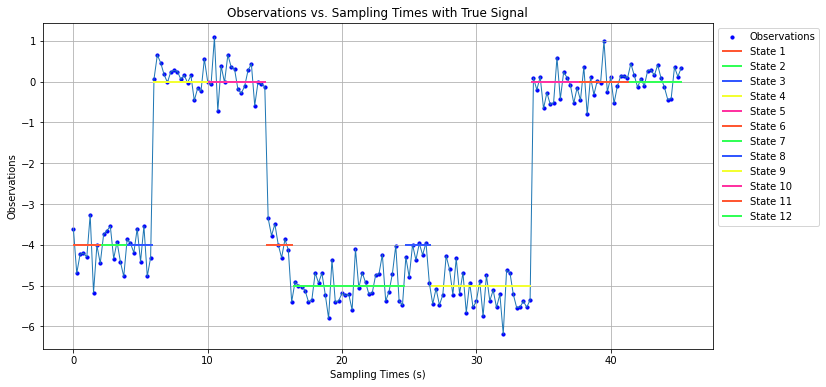

In [95]:
plot_observations_with_true_signal(sampling_times, observations, state_sequence, states, durations)

### Applying the Viterbi Algorithm to the Generated Sequence

In [96]:
num_states = len(states)
start_prob = np.repeat(1/num_states, num_states)

In [97]:
viterbi_out            = viterbi_algorithm(observations, states, start_prob, transition_matrix)
log_viterbi_out        = log_viterbi_algorithm(observations, states, start_prob, transition_matrix)
most_probable_path     = viterbi_out[0]
most_probable_path_log = log_viterbi_out[0]
print("Most probable path (head):", most_probable_path[:10])

Most probable path (head): [3, 4, 3, 3, 3, 3, 4, 3, 3, 3]


In [177]:
# Trying an average of the predictions over many chunk sizes:
num_L = 9

num_obs = len(observations)
all_pointwise = []
for L in range(1, num_L+1):
    chunked_out  = log_viterbi_algo_chunks(observations, states, start_prob, transition_matrix, L)
    chunked_path = chunked_out[0]
    
    pointwise = chunks_to_pointwise(observations, L, chunked_path)
    all_pointwise.append(pointwise)
    
avg_pointwise = np.zeros(num_obs)
var_pointwise = np.zeros(num_obs)
for i in range(num_obs):
    avg_pointwise[i] = np.round(np.mean([x[i] for x in all_pointwise]))
    var_pointwise[i] = np.var([x[i] for x in all_pointwise])

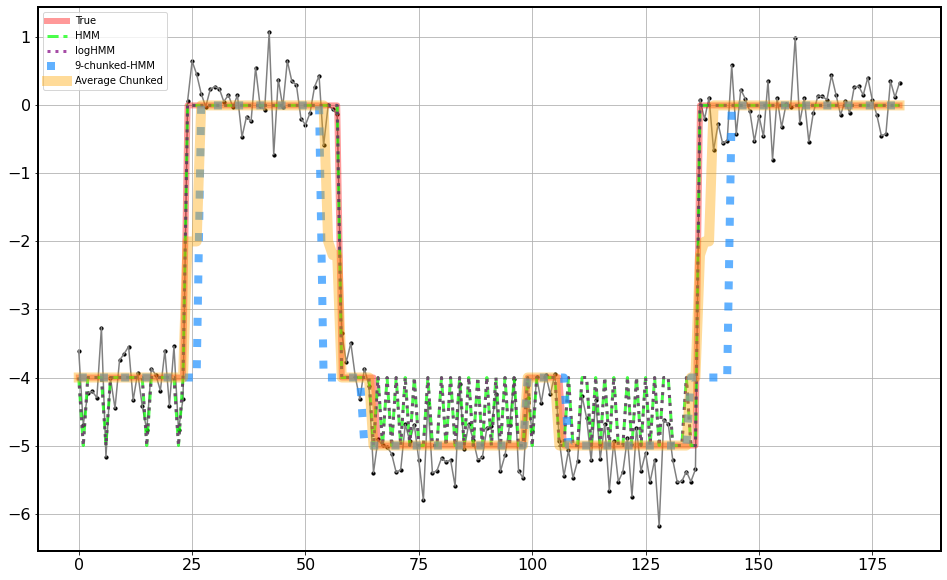

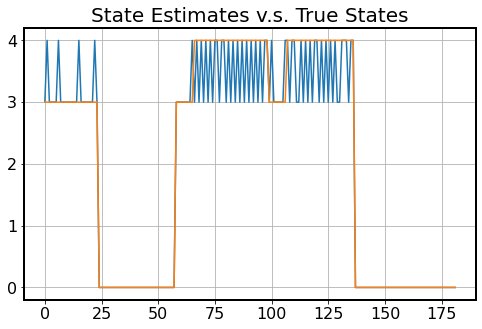

In [179]:
fig, ax = plt.subplots(figsize=(16.18, 10))
ax.plot(observations, c='gray')
ax.plot(np.array([means[x] for x in true_states]), c='red', label='True', alpha=0.4, lw=6)
ax.scatter(np.arange(len(observations)), observations, s=10, c='black')
ax.plot(np.array([means[x] for x in most_probable_path]), c='lime', label='HMM', alpha=0.7, lw=3, ls='dashed')
ax.plot(np.array([means[x] for x in most_probable_path_log]), c='purple', label='logHMM', alpha=0.7, lw=3, ls='dotted')
ax.plot(np.array([means[x] for x in pointwise]), c='dodgerblue', label='{}-chunked-HMM'.format(L), alpha=0.7, lw=8, ls='dotted')
ax.plot(np.array([means[int(x)] for x in avg_pointwise]), c='orange', label='Average Chunked', alpha=0.4, lw=10)
ek.make_pretty(ax)
ax.legend()

fig, ax = plt.subplots(figsize=np.array([16.18, 10])*0.5)
ax.plot(most_probable_path_log)
ax.plot(true_states)
ek.make_pretty(ax, title='State Estimates v.s. True States')

# **Adding Some Physics $\rightarrow$ The Two-Stage Model with Vector Emissions from States**

The previous approach suffers from transition temptation (explained elsewhere). To overcome it, we should apply the physics-informed step durations. This approach effectively creates a time-dependent transition matrix, where the elements in a matrix are functions of the duration of a step.

In this approach, a state manifests as a vector of emissions where the length of the vector follows a probability distribution characteristic of the state. This is in contrast to the simple HMM where states are considered pointwise (i.e. where one state emits one point). In the simple HMM, you are effectively modelling the duration distribution of a state as geometric (this is explained elsewhere), where the parameter of the distribution is related to the self-transition probability. In practice, duration distributions need not be geometric. 


There are at least two ways to introduce a general duration distribution to the HMM:

    1) Two-stage model where changepoints between states are detected by an external algorithm that passes changepoints to the HMM
    2) End-to-end model where the HMM serves as its own changepoint indicator. This approach necessitates the use of the Hidden Semi-Markov Model (HSMM)
    
In this section, we consider the simpler two-stage approach. Its performance is excellent when the changepoints are correctly identified. In fact, the performance is exceptional even when changepoints indices are slightly noisy. However, when an incorrect number of changepoints is detected, this approach performs poorly.

In [103]:
segments = split_time_series(observations, changepoint_indices)

In [104]:
log_viterbi_vector_out = viterbi_algorithm_vector_new(segments, states, start_prob, transition_matrix, 1./sample_rate, tol=1e-8)

C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:174: RuntimeWarning: divide by zero encountered in log
  log_joint_density = np.log(ndensity) + log_xdensity


In [105]:
est_vector_states = log_viterbi_vector_out[0]
est_vector_states

[3, 3, 3, 0, 0, 3, 4, 3, 4, 0, 0, 0]

In [106]:
nobs_per_segment = [len(x) for x in segments]
print(nobs_per_segment)

[9, 8, 7, 16, 18, 8, 33, 8, 30, 14, 15, 16]


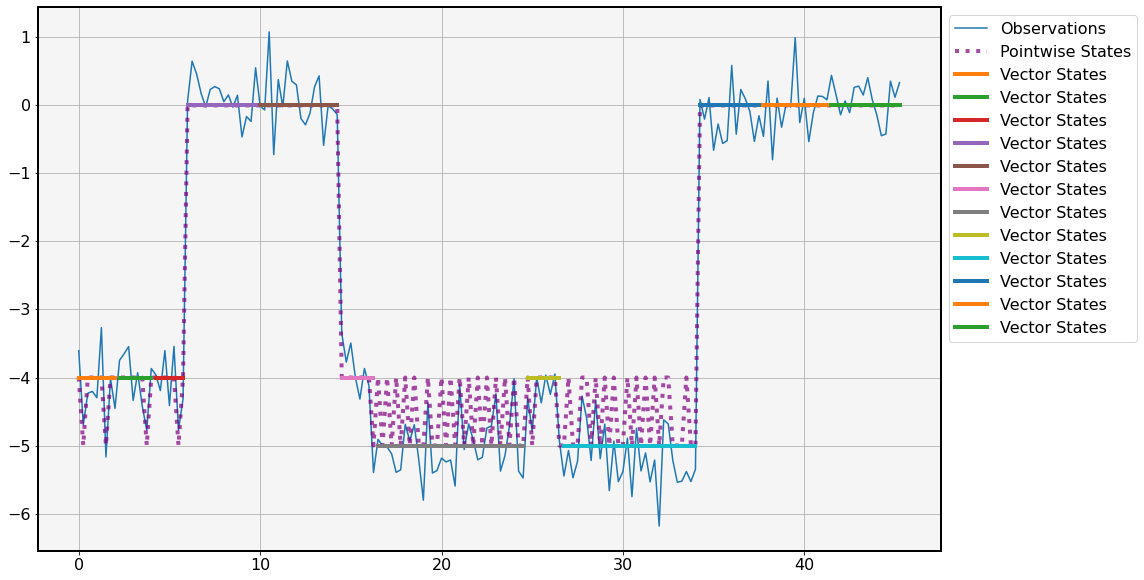

In [107]:
fig, ax = plt.subplots(figsize=(16.18, 10))
ax.plot(sampling_times, observations, label='Observations')
ax.plot(sampling_times, np.array([means[x] for x in most_probable_path_log]), c='purple', label='Pointwise States', alpha=0.7, lw=4, ls='dotted')
est_num_vector_states = len(est_vector_states)
nobs        = np.sum(nobs_per_segment)
start_index = 0

for i in range(est_num_vector_states):
    end_index   = start_index + nobs_per_segment[i] - 1

    plt.plot((sampling_times[start_index], sampling_times[end_index]),
             (means[est_vector_states[i]], means[est_vector_states[i]]), lw=4, label='Vector States')

    start_index      = end_index + 1
    
ek.make_pretty(ax)
ax.set_facecolor("whitesmoke")
ax.legend(fontsize=16, bbox_to_anchor=(1,1), loc='upper left')

**Comments:**

Notice how the algorithm is perfect. Of course, this assumes that we can accurately label the changepoints. It turns out that the algorithm is still very good if the total number of changepoints is correct but their locations are a bit noisy. You end up with correct steps with edge regions that bleed into incrorrect steps. However, this can likely be remedied with some kind of "best shift" algorithm that trials shifts of the original changepoints and chooses a shift that minimizes some loss function. You could then compute the compare the probability of the shifted estimates to the probability of the original estimates to see if the shifted sequence is more probable than the original sequence. 


However, if the total number of changepoints is incorrect, results can be quite poor and there isn't an obvious fix that can be easily automated.

Therefore, if you have a dataset which you believe can be easily tagged with a changepoint algorithm, this vectorized stare approach is quite powerful. If the changepoints are not reliable, try other variations fo the Viterbi algorithm.

# **Pointwise Sate Estimation $\rightarrow$ Applying the Forward-Backward Algorithm**

The Forward-Backward Algorithm can be used to obtain the pointwise best estimates for the hidden state corresponding to an observed emission. This is different from the Viterbi algorithm which estimates the most likely overall sequence of states. In general, the solutions are different. 

The Forward-Backward algorithm will produce a solution which maximizes the number of correctly estimated pointwise states. Interestingly, this is not necessarily, and usual is not, the most likely state sequence.


Why would we use this or the Viterbi algorithm? Using the Viterbi algorithm is useful when the order in which states occur has some external physical significance which makes some orders "mean something" while other orders do not.

The Forward-Backward algorithm is useful in general classification tasks where the order is not relevant and we simply want to maximize the number of correctly calssified states. Given that we're using HMMs at all, it suggests that we are interested in the Viterbi solution, but the Forward-Backward solution is nevertheless interesting in our context. We'll see how, next.



In our case, we will try to correct mistakes made by the Viterbi algorithm by using the Forward-Backward algorithm. If the Viterbi algorithm does not account for state duration, it will produce a large amount of spikes corresponding to incorrect state changes.

We have, however, additional information: states manifest for a period of time over which a sequence of emissions is observed. For example, since states have durations longer than one data sample, it is extremely unlikely to have a long sequence of points belonging to the same class, a rapid single sample of another state class, and then back to a long sequence from the first state-class. It's much more likely that the Viterbi algorithm made a mistake (as it will, since the data is noisy and there is overlap in the emission distributions of the different state-classes), and that all of the emissions are manifestations of the first state-class. 

Using the Forward-Backward algorithm, we can correct these sorts of mistakes. One approach would be to use the Forward-Backward algorithm to check the posterior probabilities of the Viterbi state estimates, and switch to the Forward-Backward algorithm solution if the Viterbi solution is highly unlikely on a pointwise evaluation.

This simple approach easily automates the task of correcting the incorrect spikes produced by the Viterbi algorithm. A downside of this approach is that its na



## **The Basic FB-Algorithm**

In [108]:
fbalgo_out = forward_backward_log(observations, states, np.log(start_prob), np.log(transition_matrix))
#fbalgo_out_prod = forward_backward_algorithm(observations, states, start_prob, transition_matrix)

C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1175355878.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forward_log_table[0][s] = start_log_prob[s] + math.log(states[s].emission_probability(obs[0]))
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1175355878.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forward_log_table[t][s] = log_sum_exp(log_probs) + math.log(states[s].emission_probability(obs[t]))
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1175355878.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your ar

(array([657.,  16.,  22.,  20.,  13.,  13.,  20.,  22.,  16., 111.]),
 array([6.30080936e-82, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

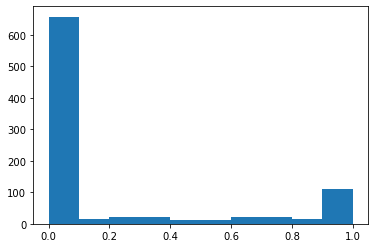

In [109]:
plt.hist(np.concatenate(fbalgo_out[0]))

(array([79.,  0.,  0.,  0.,  0.,  0.,  0., 56.,  0., 47.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

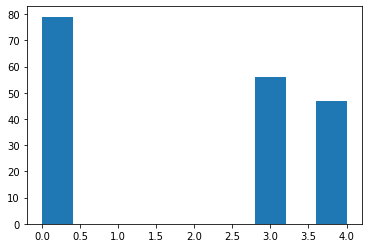

In [110]:
plt.hist(fbalgo_out[1])

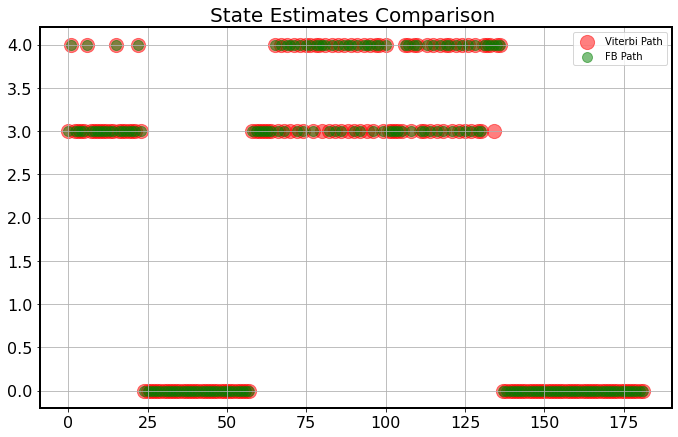

In [183]:
fig, ax = plt.subplots(figsize=(16.18*0.7, 10*0.7))
tt = np.arange(nobs)
ax.scatter(tt, most_probable_path_log, c='red', label='Viterbi Path', alpha=0.5, s=200)
ax.scatter(tt, fbalgo_out[1],c='green', label='FB Path',alpha=0.5, s=100)
#ax.scatter(tt, fbalgo_out_prod[1],c='purple', label='Greedy Path - Products',alpha=0.5, s=100)
ek.make_pretty(ax, title='State Estimates Comparison ')
ax.legend()

**Comments**

Clearly, in this dataset, the two algorithms produce nearly identical predictions. 

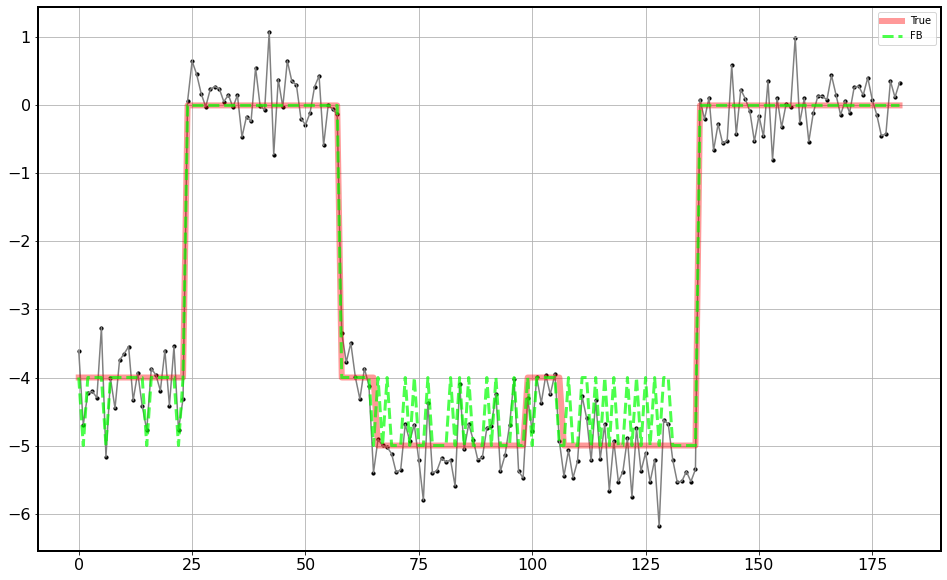

In [184]:
fig, ax = plt.subplots(figsize=(16.18, 10))
ax.plot(observations, c='gray')
ax.plot(np.array([means[x] for x in true_states]), c='red', label='True', alpha=0.4, lw=6)
ax.scatter(np.arange(len(observations)), observations, s=10, c='black')
ax.plot(np.array([means[x] for x in fbalgo_out[1]]), c='lime', label='FB', alpha=0.7, lw=3, ls='dashed')
#ax.plot(np.array([means[x] for x in most_probable_path_log]), c='purple', label='logHMM', alpha=0.7, lw=3, ls='dotted')
ek.make_pretty(ax)
ax.legend()

In [114]:
jake_path = most_probable_path_log.copy()

(array([  2.,   2.,   5.,   7.,  11.,  13.,  15.,  11.,  12., 104.]),
 array([0.35024919, 0.41522427, 0.48019935, 0.54517443, 0.61014951,
        0.67512459, 0.74009967, 0.80507476, 0.87004984, 0.93502492,
        1.        ]),
 <BarContainer object of 10 artists>)

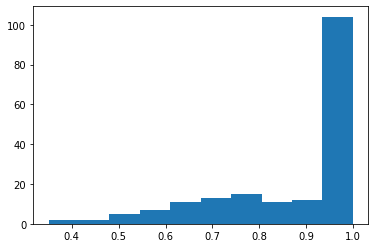

In [115]:
plt.hist([fbalgo_out[0][i][jake_path[i]] for i in range(nobs)])

In [116]:
for i in range(nobs):
    viterbi_state = jake_path[i]
    if fbalgo_out[0][i][viterbi_state] < 0.5:
        if viterbi_state != fbalgo_out[1][i]:
            print(fbalgo_out[0][i])
            print(jake_path[i])
            print(fbalgo_out[1][i])
            jake_path[i] = fbalgo_out[1][i]


[3.5949106120392343e-63, 6.114463205920067e-25, 6.589190768852001e-25, 0.35024918677666556, 0.6497508132233274]
3
4
[1.199586919421549e-58, 3.1376064286885e-22, 4.8948526323067146e-21, 0.44583969203838403, 0.5541603079616177]
3
4
[3.666991545081825e-59, 1.4784009349907215e-22, 1.74825762695844e-21, 0.4210075959299785, 0.5789924040700224]
3
4
[8.153880751336605e-58, 1.1509916402856762e-21, 2.66172662703723e-20, 0.48915815877520313, 0.5108418412247983]
3
4
[6.815452754019488e-63, 1.0129393763056843e-24, 1.2682360952271129e-24, 0.37582981478268823, 0.6241701852172932]
3
4


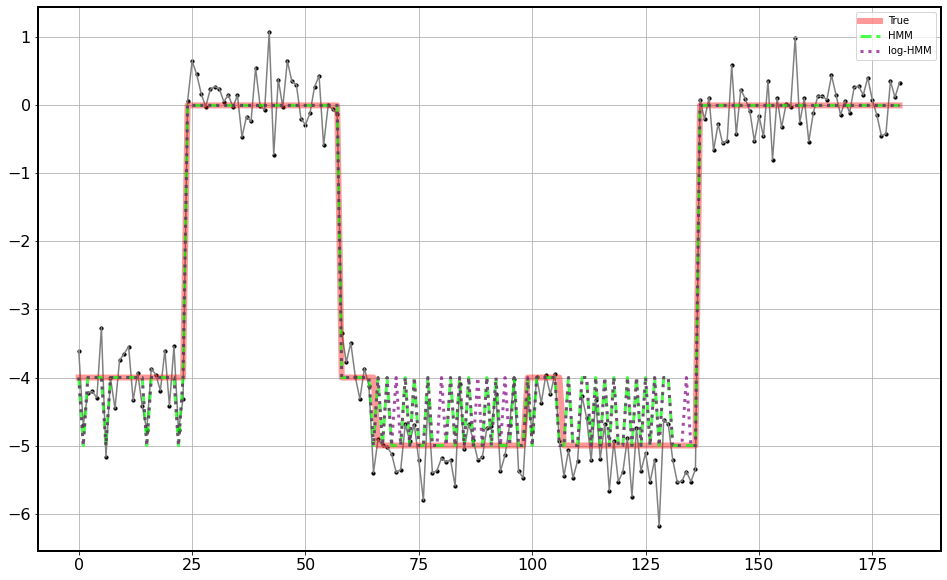

In [117]:
fig, ax = plt.subplots(figsize=(16.18, 10))
ax.plot(observations, c='gray')
ax.plot(np.array([means[x] for x in true_states]), c='red', label='True', alpha=0.4, lw=6)
ax.scatter(np.arange(len(observations)), observations, s=10, c='black')
ax.plot(np.array([means[x] for x in jake_path]), c='lime', label='HMM', alpha=0.7, lw=3, ls='dashed')
ax.plot(np.array([means[x] for x in most_probable_path_log]), c='purple', label='log-HMM', alpha=0.7, lw=3, ls='dotted')
#ax.plot(np.array([means[x] for x in most_probable_path_log]), c='purple', label='logHMM', alpha=0.7, lw=3, ls='dotted')
ek.make_pretty(ax)
ax.legend()

## **Considering the Expected Value of the Posterior in the FB-Algorithm**

In [118]:
posterior_exp   = [np.dot(x, means) for x in fbalgo_out[0]]

posterior_state =  [np.argmax([s.emission_probability(x) for s in states]) for x in posterior_exp]

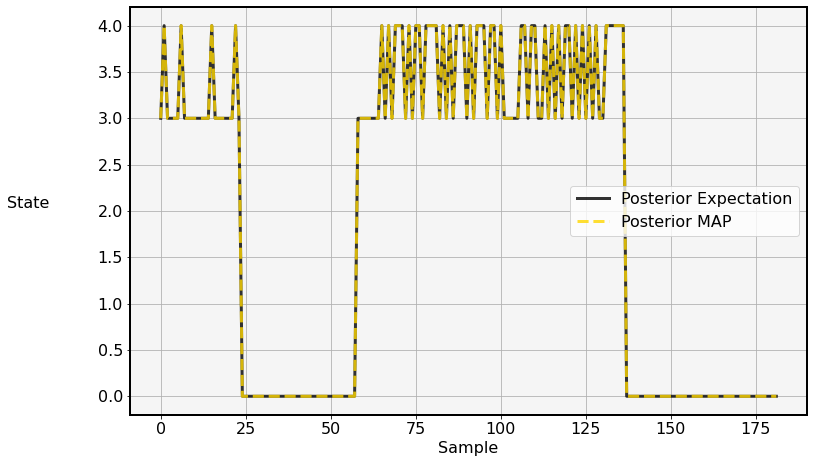

In [119]:
scale = 0.75
fig, ax = plt.subplots(figsize=goldendims*scale)
ax.plot(posterior_state, c='black', lw=3, alpha=0.8, label='Posterior Expectation')
ax.plot(fbalgo_out[1], c='gold', lw=3, alpha=0.8, label='Posterior MAP', ls='dashed')

ek.make_pretty(ax, xTitle='Sample', yTitle='State')
ax.set_facecolor('whitesmoke')
ax.legend(fontsize=16)

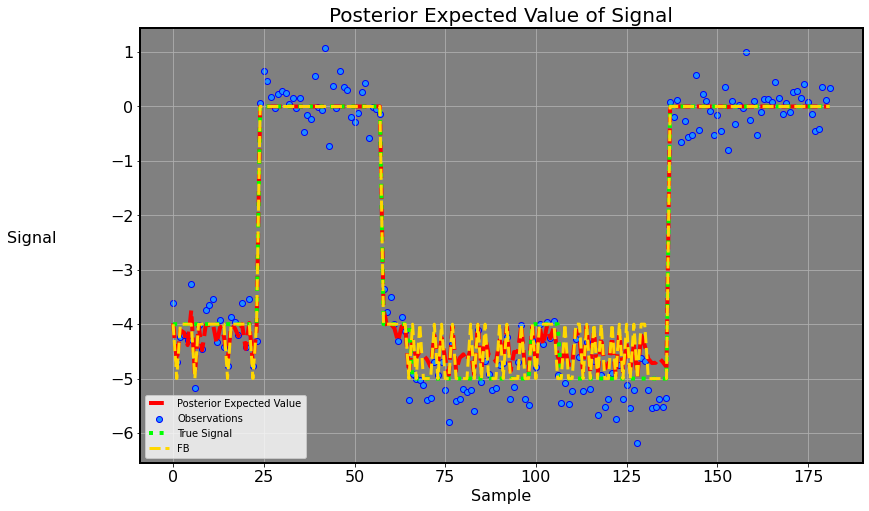

In [120]:
scale   = 0.8
fig, ax = plt.subplots(figsize=goldendims*scale)
ax.plot(posterior_exp, c='red', lw=4, ls='dashed', label='Posterior Expected Value')
ax.scatter(np.arange(num_obs), observations,edgecolor='blue',c='dodgerblue', label='Observations')
ax.plot([means[x] for x in true_states], c='lime', lw=4, ls='dotted', label='True Signal')
ax.plot(np.array([means[x] for x in fbalgo_out[1]]), c='gold', label='FB', lw=3, ls='dashed')
ek.make_pretty(ax, xTitle='Sample', yTitle='Signal', title='Posterior Expected Value of Signal')
ax.set_facecolor('grey')
ax.legend()

# **Jacob's HSMM**

The typical setup of the HSMM is problematic due to its computational complexity (quadratic in state duration, measured in number of samples, not in time). Here, we formulate an algorithm that maintains the spirit of the HSMM (in that duration of state is a relvant variable in transition probability), while reducing the computational cost relative to the standard HSMM formulation.

We will see that this approach has its own limitations related to state "stickiness".

## N Running Counts Approach

In [121]:
cdf_lookup_tables = []

# the below is odd.... should change it to get dmax particular to each state... I just noticed it in passing while working on something else,
# so I'm not going to fuck with it until i take a proper look
for s in states:
    dmax = get_ROI(states[0], 0.0, sample_rate, alpha_low=0.1, alpha_upp=0.9999)[1]
    cdf_lookup_tables.append(get_cumulative_lookup(s.duration_dist, 0, sample_rate, dmax, s.duration_dist_params))

C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:396: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nlow = floor(low_cut*sample_rate)
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:397: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nupp = ceil(upp_cut*sample_rate)


In [122]:
JHSMM_weak_out               = JHSMM_weak(observations, states, start_prob, transition_matrix, sample_rate, cdf_lookup_tables)
JHSMM_strong_out             = JHSMM_strong(observations, states, start_prob, transition_matrix, sample_rate, cdf_lookup_tables)

burn_in = 3
JHSMM_strong_regularized_out = JHSMM_strong_regularized(observations, states, start_prob, transition_matrix, sample_rate, cdf_lookup_tables, burn_in)

C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1958177495.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  viterbi_probs[0, s]      = np.log(start_prob[s]) + np.log(states[s].emission_probability(observations[0]))
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1958177495.py:53: RuntimeWarning: divide by zero encountered in log
  prob = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s]) + np.log(duration_factor)
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1958177495.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  viterbi_probs[t, s]      = max_prob + np.log(states[s].emission_probability(observations[t]))
C:\Users

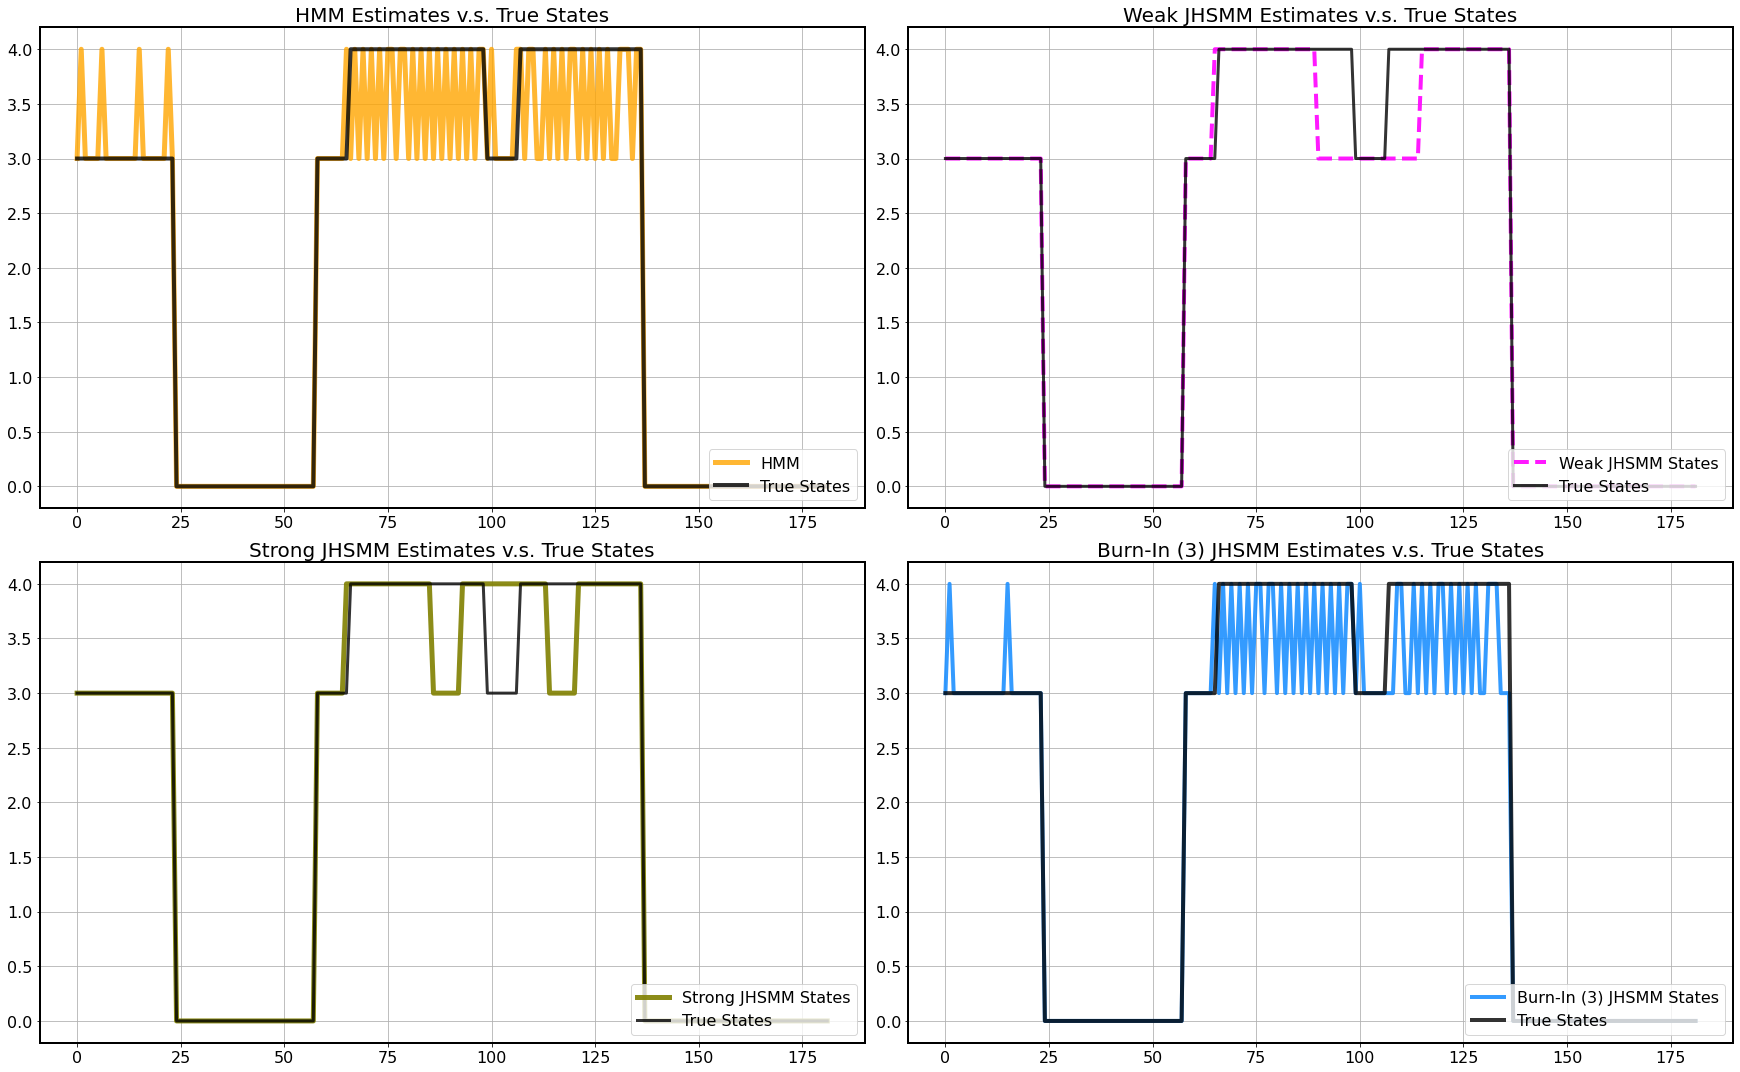

In [123]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=np.array([16.18*1.5, 10*1.5]))

ax[0][0].plot(most_probable_path_log, c='orange', label='HMM', lw=5, alpha=0.8)
ax[0][0].plot(true_states, label='True States', c='black', lw=4, alpha=0.8)

ax[0][1].plot(JHSMM_weak_out[0], label='Weak JHSMM States', c='magenta', ls='dashed', lw=4, alpha=0.9)
ax[0][1].plot(true_states, label='True States', c='black', lw=3, alpha=0.8)


ax[1][0].plot(JHSMM_strong_out[0], label='Strong JHSMM States', c='olive', lw=5, alpha=0.9)
ax[1][0].plot(true_states, label='True States', c='black', lw=3, alpha=0.8)


ax[1][1].plot(JHSMM_strong_regularized_out[0], label='Burn-In ({}) JHSMM States'.format(burn_in), c='dodgerblue', lw=4, alpha=0.9)
ax[1][1].plot(true_states, label='True States', c='black', lw=4, alpha=0.8)

#
ek.make_pretty(ax[0][0], title='HMM Estimates v.s. True States')
ek.make_pretty(ax[0][1], title='Weak JHSMM Estimates v.s. True States')
ek.make_pretty(ax[1][0], title='Strong JHSMM Estimates v.s. True States')
ek.make_pretty(ax[1][1], title='Burn-In ({}) JHSMM Estimates v.s. True States'.format(burn_in))
ax[0][0].legend(fontsize=16, loc='lower right', bbox_to_anchor=(1,0))
ax[0][1].legend(fontsize=16, loc='lower right', bbox_to_anchor=(1,0))
ax[1][0].legend(fontsize=16, loc='lower right', bbox_to_anchor=(1,0))
ax[1][1].legend(fontsize=16, loc='lower right', bbox_to_anchor=(1,0))
fig.tight_layout()

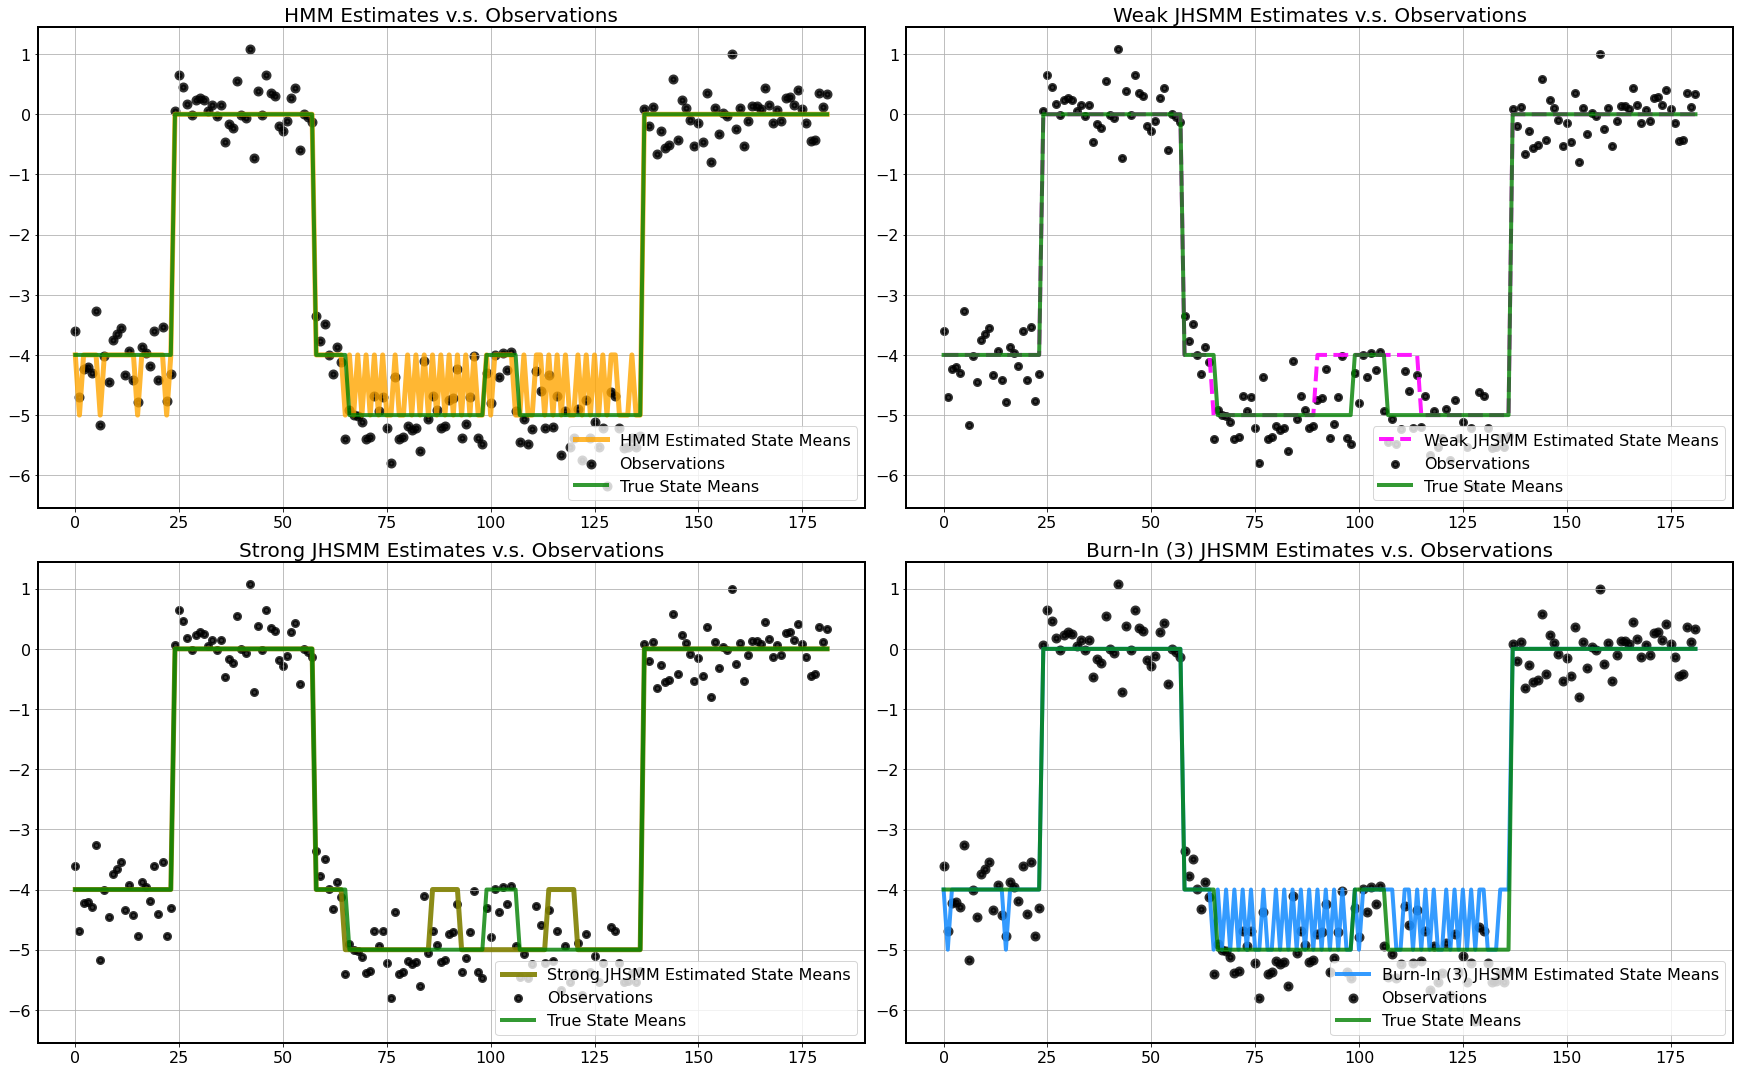

In [191]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=np.array([16.18*1.5, 10*1.5]))

ax[0][0].plot(np.array([means[x] for x in most_probable_path_log]), c='orange', label='HMM Estimated State Means', lw=5, alpha=0.8)
ax[0][0].scatter(np.arange(len(observations)), observations, label='Observations', c='black', lw=4, alpha=0.8)
ax[0][0].plot(np.array([means[x] for x in true_states]), label='True State Means', c='green', lw=4, alpha=0.8)

ax[0][1].plot(np.array([means[x] for x in JHSMM_weak_out[0]]), label='Weak JHSMM Estimated State Means', c='magenta', ls='dashed', lw=4, alpha=0.9)
ax[0][1].scatter(np.arange(len(observations)), observations, label='Observations', c='black', lw=3, alpha=0.8)
ax[0][1].plot(np.array([means[x] for x in true_states]), label='True State Means', c='green', lw=4, alpha=0.8)

ax[1][0].plot(np.array([means[x] for x in JHSMM_strong_out[0]]), label='Strong JHSMM Estimated State Means', c='olive', lw=5, alpha=0.9)
ax[1][0].scatter(np.arange(len(observations)), observations, label='Observations', c='black', lw=3, alpha=0.8)
ax[1][0].plot(np.array([means[x] for x in true_states]), label='True State Means', c='green', lw=4, alpha=0.8)

ax[1][1].plot(np.array([means[x] for x in JHSMM_strong_regularized_out[0]]), label='Burn-In ({}) JHSMM Estimated State Means'.format(burn_in), c='dodgerblue', lw=4, alpha=0.9)
ax[1][1].scatter(np.arange(len(observations)), observations, label='Observations', c='black', lw=4, alpha=0.8)
ax[1][1].plot(np.array([means[x] for x in true_states]), label='True State Means', c='green', lw=4, alpha=0.8)
#
ek.make_pretty(ax[0][0], title='HMM Estimates v.s. Observations')
ek.make_pretty(ax[0][1], title='Weak JHSMM Estimates v.s. Observations')
ek.make_pretty(ax[1][0], title='Strong JHSMM Estimates v.s. Observations')
ek.make_pretty(ax[1][1], title='Burn-In ({}) JHSMM Estimates v.s. Observations'.format(burn_in))
ax[0][0].legend(fontsize=16, loc='lower right', bbox_to_anchor=(1,0))
ax[0][1].legend(fontsize=16, loc='lower right', bbox_to_anchor=(1,0))
ax[1][0].legend(fontsize=16, loc='lower right', bbox_to_anchor=(1,0))
ax[1][1].legend(fontsize=16, loc='lower right', bbox_to_anchor=(1,0))
fig.tight_layout()

**Comments**

The performance improvements are evident when we apply the JHSMM variations. 

1) The Strong JHSMM with burn-in evidently has performance liitations for states instances of short duration
2) The Weak JHSMM appears to have the best performance. This is unexpected and, in fact, the Weak JHSMM was discovered by accident. Further investigation into why it works is to be explored.
3) The Strong JHSMM also performs very well relative to the HMM, but appears to perform worse than the Weak JHSMM. Whether this trend generalizes to all datasets is unknown.

4) The burn-in variation of the strong JHSMM is intended to combat the "stickiness" problem of the JHSMM. The incorrect estimates are less sticky (they correct themselves more rapidly - i.e. the incorrect spikes don't have a long plateau), but are more frequent. This makes sense because we're running a basic HMM during the burn-in period.



Which is best? The burn-in method should likely be discarded as it doesn't fix the main problem of the HMM (i.e. you still end up with rapid spikes because the burn-in period is just an HMM). The JHSMM can likely have some kind of wrapper algorithm pass back over its estimates and correct its incorrect regions. For example, a forward-backward algorithm (mathematics adjusted to match the mathematics of this variation of the Viterbi algorithm) could be used to make corrections. I have yet to develop the mathematics for the adjusted forward-backward algorithm, which is more complicated than the Viterbi algorithm.

### Trying a Harder Sequence

In [192]:
means     = [0 , -2 , -2.2  , -4, -5]  # Different means for samples from each class
variance  = np.array([0.1, 0.1, 0.05, 0.3, 0.2])# Different variances for samples for each class

d = 4 # pore length.. ideally constant but likely has a distribution in practice.. Normal distribution? Dunno... 
dvs_params = [
                 [d, 1  , 0.14],
                 [d, 2.7, 0.09],
                 [d, 0.3, 0.12],
                 [d, 2  , 0.05],
                 [d, 0.5, 0.1]
             ]

Transition Matrix:
[[0.24116529 0.06975013 0.35459775 0.10587913 0.22860769]
 [0.16667784 0.33853702 0.09591171 0.02538703 0.3734864 ]
 [0.34871308 0.37536877 0.16251163 0.0037673  0.10963923]
 [0.17153682 0.13762242 0.21006761 0.23214254 0.24863061]
 [0.24733338 0.18157104 0.18721119 0.14150708 0.24237732]]
Randomly Chosen State Index: 4
Generated State Sequence: [3, 1, 2, 4, 0, 0, 2]
Generated Durations for State Sequence: [1.9795643238555702, 1.4896829141906118, 9.805089346965788, 7.87904812850529, 4.609482389069213, 4.376085499143163, 9.801468410508148]
Generated Sampling Times (head):
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9]
Sampled Observations (head):
 [-3.45840961 -3.64229945 -3.95498604 -5.01470555 -4.54052117 -4.23860534
 -3.53933959 -4.88545546 -3.27367738 -3.64871492]


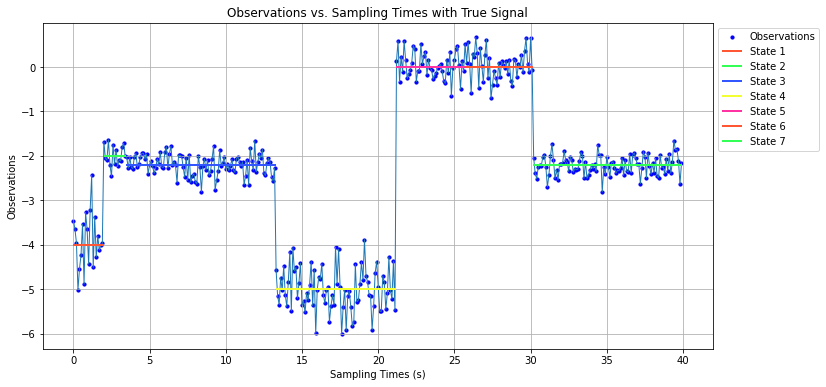

C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:396: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nlow = floor(low_cut*sample_rate)
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:397: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nupp = ceil(upp_cut*sample_rate)


In [193]:
obs_hard, true_states_hard, true_durations_hard, changepoints_hard, states_hard, transition_matrix_hard, cdf_hard, state_sequence= create_dataset(10, means, variance, d, dvs_params)

In [194]:
def average_chunked_HMM(observations, states, start_prob, transition_matrix, num_L=1):


    num_obs = len(observations)
    all_pointwise = []
    for L in range(1, num_L+1):
        chunked_out  = log_viterbi_algo_chunks(observations, states, start_prob, transition_matrix, L)
        chunked_path = chunked_out[0]

        pointwise = chunks_to_pointwise(observations, L, chunked_path)
        all_pointwise.append(pointwise)

    avg_pointwise = np.zeros(num_obs)
    var_pointwise = np.zeros(num_obs)
    for i in range(num_obs):
        avg_pointwise[i] = np.round(np.mean([x[i] for x in all_pointwise]))
        var_pointwise[i] = np.var([x[i] for x in all_pointwise])

    
    return avg_pointwise, var_pointwise

In [195]:
JHSMM_weak_hard_out               = JHSMM_weak(obs_hard, states_hard, start_prob, transition_matrix, sample_rate, cdf_hard)
JHSMM_strong_hard_out             = JHSMM_strong(obs_hard, states_hard, start_prob, transition_matrix, sample_rate, cdf_hard)



burn_in = 3
JHSMM_strong_regularized_hard_out = JHSMM_strong_regularized(obs_hard, states_hard, start_prob, transition_matrix, sample_rate, cdf_hard, burn_in)



log_viterbi_hard_out        = log_viterbi_algorithm(obs_hard, states_hard, start_prob, transition_matrix)
most_probable_path_hard     = log_viterbi_hard_out[0]


avg_chunk_hard_out = average_chunked_HMM(obs_hard, states_hard, start_prob, transition_matrix, 9)


C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1958177495.py:53: RuntimeWarning: divide by zero encountered in log
  prob = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s]) + np.log(duration_factor)
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1958177495.py:133: RuntimeWarning: divide by zero encountered in log
  log1            = np.log(1. - trans_prob[prev_s][s]) + np.log(cdf_table[prev_s][d_prevailing])
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1958177495.py:130: RuntimeWarning: divide by zero encountered in log
  prob = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s]) + np.log(duration_factor)
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1958177495.py:211: RuntimeWarning: divide by zero encountered in log
  prob = viterbi_probs[t-1, prev_s] + np.log(trans_prob[prev_s][s]) + np.log(duration_factor)
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\1958177495.py:214: RuntimeWarning: divide by zero encountered in log
  log1            = np.log(1. - 

In [196]:
JHSMM_strong_hard_out[2][:10]

array([[ 1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6],
       [ 7,  7,  7,  7,  7],
       [ 1,  8,  8,  8,  8],
       [ 1,  9,  9,  9,  9],
       [ 1, 10,  1, 10, 10]])

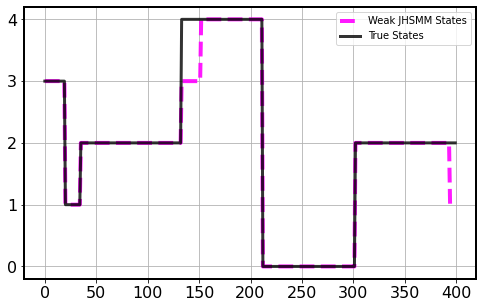

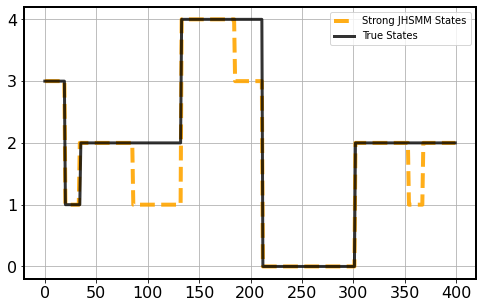

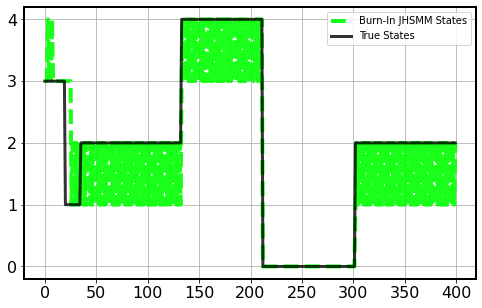

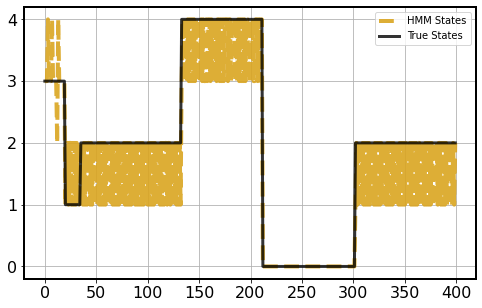

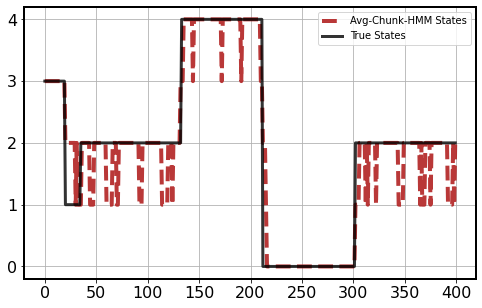

In [197]:
fig, ax = plt.subplots(figsize=np.array([16.18, 10])*0.5)
ax.plot(JHSMM_weak_hard_out[0], label='Weak JHSMM States', c='magenta', ls='dashed', lw=4, alpha=0.9)
ax.plot(true_states_hard, label='True States', c='black', lw=3, alpha=0.8)
ek.make_pretty(ax)
ax.legend()


fig, ax = plt.subplots(figsize=np.array([16.18, 10])*0.5)
ax.plot(JHSMM_strong_hard_out[0], label='Strong JHSMM States', c='orange', ls='dashed', lw=4, alpha=0.9)
ax.plot(true_states_hard, label='True States', c='black', lw=3, alpha=0.8)
ek.make_pretty(ax)
ax.legend()

fig, ax = plt.subplots(figsize=np.array([16.18, 10])*0.5)
ax.plot(JHSMM_strong_regularized_hard_out[0], label='Burn-In JHSMM States', c='lime', ls='dashed', lw=4, alpha=0.9)
ax.plot(true_states_hard, label='True States', c='black', lw=3, alpha=0.8)
ek.make_pretty(ax)
ax.legend()


fig, ax = plt.subplots(figsize=np.array([16.18, 10])*0.5)
ax.plot(most_probable_path_hard , label='HMM States', c='goldenrod', ls='dashed', lw=4, alpha=0.9)
ax.plot(true_states_hard, label='True States', c='black', lw=3, alpha=0.8)
ek.make_pretty(ax)
ax.legend()

fig, ax = plt.subplots(figsize=np.array([16.18, 10])*0.5)
ax.plot(avg_chunk_hard_out[0] , label='Avg-Chunk-HMM States', c='firebrick', ls='dashed', lw=4, alpha=0.9)
ax.plot(true_states_hard, label='True States', c='black', lw=3, alpha=0.8)
ek.make_pretty(ax)
ax.legend()


# **Traditional HSMMs**

The approaches in the previous section showed superior performance to the basic HMM. They are also fast algorithms, providing a result essentially instantly in the perception of the user. However, we did see that they do still make mistakes in difficult regions where different states overlap in their emissions. 

In this section, we develop a complete HSMM. This algorithm is much slower than the previously considered algorithms, but it should also be much more powerful.

Some alterations to the Viterbi algorithm for HSMMs are made with the objective of reducing computational complexity and memory requirements. Without these alterations, it is not feasible to use the algorithm at all once datasets have on the order of hundreds of data points. Since we intend to have much larger datasets than that, we must reduce the complexity of the anive algorithm. We will make use of recursion and sliding windows to reduce redundant calculations. This will eliminate quadratic complexity in the duration parameter, and render the complexity linear.


In [157]:
def viterbi_hsmm_recurdur_fly_2(obs, states, start_prob, transition_matrix, min_duration, max_duration, sample_rate, cdf_lookup):
    num_states = len(states)
    num_obs    = len(obs)

    #min_duration = np.repeat(2, len(states))
    # Log-probability tables
    log_viterbi_table = []
    valid_state_table = []
    backpointer       = [] # [[np.array([None, None]) for _ in range(num_states)] for _ in range(num_obs)]  # Stores [prev_state, duration]

    # Log of the transition matrix:
    log_transition_matrix = np.log(transition_matrix)

    # Recurrence (includes initialization logic for t = 0)
    for t in range(num_obs):
        log_viterbi_table.append([])
        valid_state_table.append([])
        backpointer.append([])
        for s in range(num_states):
            log_viterbi_table[t].append([])
            valid_state_table[t].append([])
            backpointer[t].append([])
            # Initialize log of the joint emission probability for recursive calculation. We pre-calculate up to the minimum duration minus one.
            # Why minus one? Because it allows us to add a single new emission to the sum as we loop over valid durations beginning at the minimum
            # duration. If we did not include the "minus one", then the minimum duration would be a special case and we would require an if-statement
            # to check the value of duration at each iteration in the loop. 
            
                
            
            if t > 0:
                log_emission_prob  = np.log(states[s].emission_probability(obs[t])) 
                log_emission_prob  += np.sum(np.log(states[s].emission_probability(obs[t-min_duration[s]+2:t]))) # Note that this will "wrap" if min_duration[s] > t... it doesn't matter though because, in such a scenario, we break the loop further ahead
            else:
                log_emission_prob = 0
            
            # Loop over possible values of duration, d. Note that d being within a state's maximum and minimum values does not guarantee
            # that it is a valid duration. It must also either be the first state in the sequence or have a valid prior state. To have
            # a valid prior state, the duration must be such that it leaves a sufficient number of prior points, where the number of prior 
            # points is sufficient if it is greater than or equal to the minimum duration of at least one state class.
            for d_index in range(max_duration[s] - min_duration[s] + 1):
                d = d_index + min_duration[s]
                if t - (d - 1) < 0:  # Ensure valid duration
                    break

                log_emission_prob += np.log(states[s].emission_probability(obs[t-d+1]))
                log_duration_prob  = np.log(states[s].prob_n(d, sample_rate))
                if t - (d - 1) == 0:  # Initialization case
                    # Calculate emission probability recursively      
                    if t == 0:
                        log_emission_prob  = np.log(states[s].emission_probability(obs[t]))  
                    else:
                        log_emission_prob  = np.log(states[s].emission_probability(obs[t])) 
                        log_emission_prob  += np.sum(np.log(states[s].emission_probability(obs[:t])))
                    log_prob           = np.log(start_prob[s]) + log_duration_prob + log_emission_prob
                    log_viterbi_table[t][s].append(log_prob)
                    valid_state_table[t][s].append(d)
                    backpointer[t][s].append(np.array([None, None]))
                else:  # General case where t-(d-1) > 0 --> that is, we are looking for valid states that are not the first state in the sequence
                    # List of transition probabilities along with prev_s and prev_d
                    transition_probs = []
                    for prev_s in range(num_states):
                        if valid_state_table[t-d][prev_s]:
                            #if t-(d-1) >= min(valid_state_table[t-d][prev_s]):#(min_duration[prev_s]-1):
                            for prev_d_index in range(len(valid_state_table[t-d][prev_s])):
                                        
                                # Calculate emission probability recursively
                                prev_d = valid_state_table[t-d][prev_s][prev_d_index]
                                transition_probs.append( (np.array(log_viterbi_table[t - d][prev_s][prev_d_index]) + log_transition_matrix[prev_s][s] + np.log(cdf_lookup[prev_s][prev_d]) , prev_s, prev_d))

                    if transition_probs:  # Check if transitions exist
                        # Find the index of the maximum transition probability
                        max_tuple           = max(transition_probs, key=lambda x: x[0])
                        max_transition_prob = max_tuple[0]
                        prev_s              = max_tuple[1] 
                        prev_d              = max_tuple[2]
                        
                        # Update log-probability table and valid state table:
                        log_prob           = max_transition_prob  + log_emission_prob + log_duration_prob #+ np.log(1.-cdf_lookup[s][d]) 
                        log_viterbi_table[t][s].append(log_prob)
                        valid_state_table[t][s].append(d)
                        backpointer[t][s].append(np.array([prev_s, prev_d]))

                
               

    # Traceback
    best_path = []
    best_state, best_duration_index = max(
                                    ((s, d_index) for s in range(num_states) for d_index in range(len(log_viterbi_table[-1][s]))),
                                    key=lambda x: log_viterbi_table[-1][x[0]][x[1]]
                                    )

    best_duration = valid_state_table[-1][best_state][best_duration_index]#best_duration_index + min_duration[best_state]
    best_path.append((best_state, best_duration))

    t                = num_obs - 1
    current_duration = best_duration
    bonus = backpointer
    while t - current_duration >= 0:
        

        #best_duration_index = get_best_duration_index(valid_state_table[t-best_duration])
        prev_state, prev_duration = backpointer[t][best_state][best_duration_index]

        best_path.insert(0, (prev_state, prev_duration))
        prev_duration_index = get_best_duration_index(valid_state_table[t-current_duration][prev_state], prev_duration)
        
        t                  -= current_duration
        current_duration    = prev_duration
        best_state          = prev_state
        best_duration_index = prev_duration_index
        
        if current_duration == None:
            break
    return best_path, backpointer, log_viterbi_table, valid_state_table, bonus


In [147]:
def get_best_duration_index(valid_states, best_duration):
    num_valid_states = len(valid_states)
    for i in range(len(valid_states)):
        if best_duration == valid_states[i]:
            print('Best Index: {}'.format(i))
            return i
    
    return None

In [148]:
hsmm_sample_rate = 30
#means_hsmm     = [-5, -6, -8, -10, -14]#[0 , -2 , -3  , -4, -5]#[-2., -6., -10., -14., -18.]  # Different means for samples from each class
#variance_hsmm  = np.array([0.08, 0.08, 0.01, 0.05, 0.1])# Different variances for samples for each class
means_hsmm     = [0 , -2 , -3  , -4 , -5]  # Different means for samples from each class
variance_hsmm  = np.array([0.1, 0.1, 0.05, 0.3, 0.2])# Different variances for samples for each class


d_hsmm = 4 # pore length.. ideally constant but likely has a distribution in practice.. Normal distribution? Dunno... 

dvs_params_hsmm = [
                 [d_hsmm, 1.2  , 0.14],
                 [d_hsmm, 2.7, 0.09],
                 [d_hsmm, 1.3, 0.12],
                 [d_hsmm, 2  , 0.05],
                 [d_hsmm, 1.7, 0.1]
             ]

'''
dvs_params_hsmm = [
                 [d_hsmm, 1.2  , 0.14],
                 [d_hsmm, 1.2  , 0.14],
                 [d_hsmm, 1.2  , 0.14],
                 [d_hsmm, 1.2  , 0.14],
                 [d_hsmm, 1.2  , 0.14]
             ]
'''
hsmm_num_steps = 20

hsmm_num_states = len(means_hsmm)

Transition Matrix:
[[0.22528361 0.21124738 0.03801176 0.23022293 0.29523432]
 [0.30618824 0.13543314 0.27159903 0.16404098 0.1227386 ]
 [0.06580626 0.1437249  0.26253602 0.32752951 0.2004033 ]
 [0.27542254 0.2733622  0.1392425  0.04042222 0.27155055]
 [0.22716612 0.21859982 0.0949596  0.25121483 0.20805962]]
Randomly Chosen State Index: 0
Generated State Sequence: [0, 1, 1, 3, 4, 1, 1, 2, 4, 4, 3, 1, 1, 4, 1, 4, 3, 0, 3, 2]
Generated Durations for State Sequence: [3.466118443451213, 1.5284235881517692, 1.4639430868443677, 1.991957570407358, 2.521583919336915, 1.4513328410987798, 1.4404088614178427, 3.0373971307479595, 2.165653857688127, 2.2920051383655866, 1.9842030572339828, 1.4290032083625697, 1.519049100450511, 2.303397385834075, 1.5107606861755536, 2.2650887541589806, 2.0029349794858335, 3.4609766281820327, 2.0307553032739523, 3.0444203142173962]
Generated Sampling Times (head):
 [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.

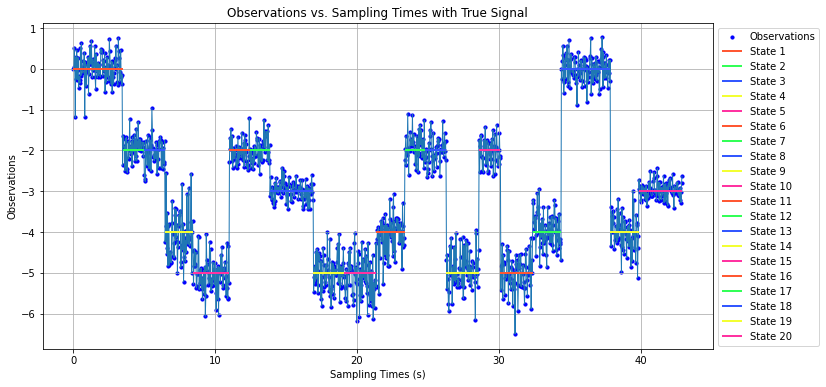

C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:396: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nlow = floor(low_cut*sample_rate)
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:397: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nupp = ceil(upp_cut*sample_rate)


In [149]:
out = create_dataset(hsmm_sample_rate, means_hsmm, variance_hsmm, d_hsmm, dvs_params_hsmm, hsmm_num_steps)

In [150]:
hsmm_obs               = np.ravel(out[0])
hsmm_true_states       = out[1]
hsmm_true_durations    = out[2]
hsmm_changepoints      = out[3]
hsmm_states            = out[4]
hsmm_transition_matrix = out[5]
hsmm_cdf_lookup        = out[6]
hsmm_state_sequence    = out[7]

In [151]:
hsmm_true_states

array([0, 0, 0, ..., 2, 2, 2])

In [152]:
ROI          = [get_ROI(S, 0.0, hsmm_sample_rate, 0.005, 0.999) for S in hsmm_states]
max_duration = np.array([x[1] for x in ROI])
min_duration = np.array([x[0] for x in ROI])

C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:396: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nlow = floor(low_cut*sample_rate)
C:\Users\jacgw\AppData\Local\Temp\ipykernel_6368\440206762.py:397: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nupp = ceil(upp_cut*sample_rate)


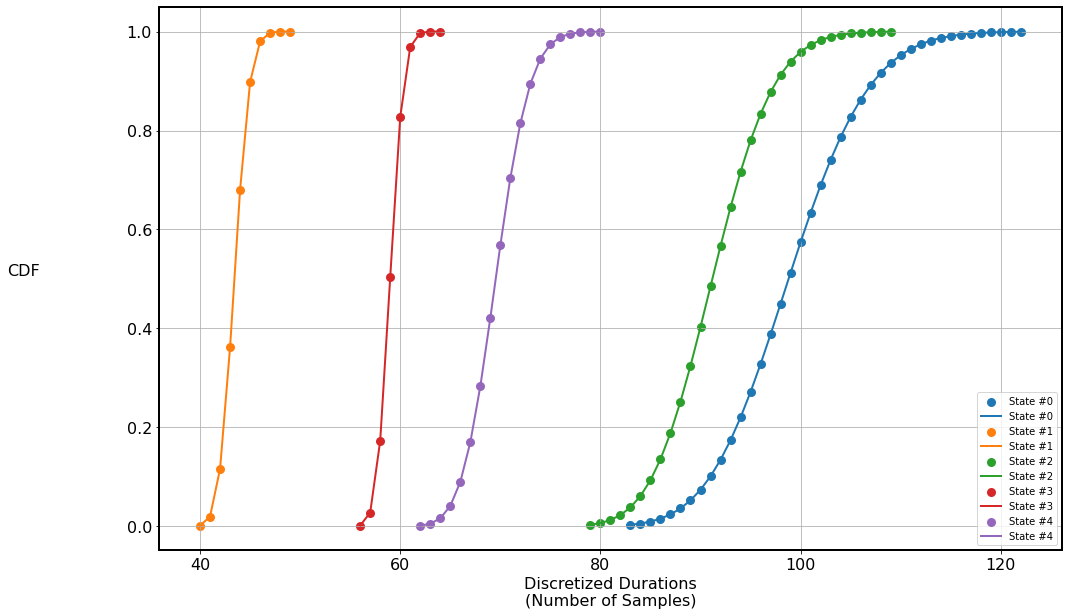

In [153]:
fig, ax = plt.subplots(figsize=np.array([16.18, 10]))
for i in range(len(hsmm_states)):
    plt.scatter(np.arange(min_duration[i]-1, max_duration[i]+1), hsmm_cdf_lookup[i][min_duration[i]-1:max_duration[i]+1], lw=3, label='State #{}'.format(i))
    plt.plot(np.arange(min_duration[i]-1, max_duration[i]+1), hsmm_cdf_lookup[i][min_duration[i]-1:max_duration[i]+1], lw=2, label='State #{}'.format(i))
ek.make_pretty(ax, xTitle='Discretized Durations\n(Number of Samples)', yTitle = 'CDF')
plt.legend()

In [154]:
print('Minimum Duration (number of samples):\n{}'.format(min_duration))
print('Maximum Duration (number of samples):\n{}'.format(max_duration))

Minimum Duration (number of samples):
[84 41 80 57 63]
Maximum Duration (number of samples):
[122  49 109  64  80]


In [155]:
hsmm_start_prob = np.repeat(1./hsmm_num_states, hsmm_num_states)

In [158]:
hsmm_out = viterbi_hsmm_recurdur_fly_2(hsmm_obs, hsmm_states, hsmm_start_prob, hsmm_transition_matrix,  min_duration, max_duration, hsmm_sample_rate, hsmm_cdf_lookup)

[[-4569.17417136046, -4600.314195521428, -4590.05707494141, -4546.081785963503, -4541.505948031424, -4581.924288405169, -4618.054122571341, -4657.624000849658, -4690.636364927081, -4774.242803341028, -4871.602483302782, -5003.794748872227, -5106.023811755879, -5200.066511624956, -5288.641353705204, -5429.903556540923, -5537.977709345137, -5640.519258523932, -5764.977857246547, -5842.009553478468, -5956.526164419229, -6023.205032938935, -6162.349338091978, -6274.549191240331, -6393.925047988484, -6539.2157065606825, -6660.464617409425, -6759.494484926521, -6858.775266564581, -6989.807063385772, -7091.711676839582, -7214.513559065068, -7427.49052733763, -7591.015291412854, -7683.441088334098, -7765.871970953026, -7854.2346426314, -7925.616522422279, -8003.627419051464], [-1032.3439094944265, -1063.2640344017411, -1066.6078125740667, -1066.1795173896369, -1065.679468810071, -1066.5452560338188, -1067.452111887195, -1069.4095441079046, -1072.8470658788517], [-892.2303898896427, -881.303953

In [164]:
hmm_out = log_viterbi_algorithm(hsmm_obs, hsmm_states, hsmm_start_prob, hsmm_transition_matrix)

In [ ]:
hmm_out = 

In [159]:
best_state    = [x[0] for x in hsmm_out[0][0:]]
best_duration = [x[1] for x in hsmm_out[0][0:]]

print(best_state)
print(best_duration)

[0, 1, 1, 3, 4, 1, 1, 2, 4, 4, 3, 1, 1, 4, 1, 4, 3, 0, 3, 2]
[104, 45, 45, 60, 76, 43, 43, 92, 67, 67, 59, 44, 44, 69, 46, 67, 61, 104, 60, 92]


In [160]:
print('Valid Ranges:')
print('--- Minimum: ({})'.format(min_duration))
print('--- Maximum: ({})'.format(max_duration))

Valid Ranges:
--- Minimum: ([84 41 80 57 63])
--- Maximum: ([122  49 109  64  80])


In [161]:
np.sum(best_duration[:])

1288

In [162]:
states_pointwise = []

num_states_est = len(best_state)
for i in range(num_states_est):
    states_pointwise.append(np.repeat(best_state[i], best_duration[i]))
    
states_pointwise = np.concatenate(states_pointwise)

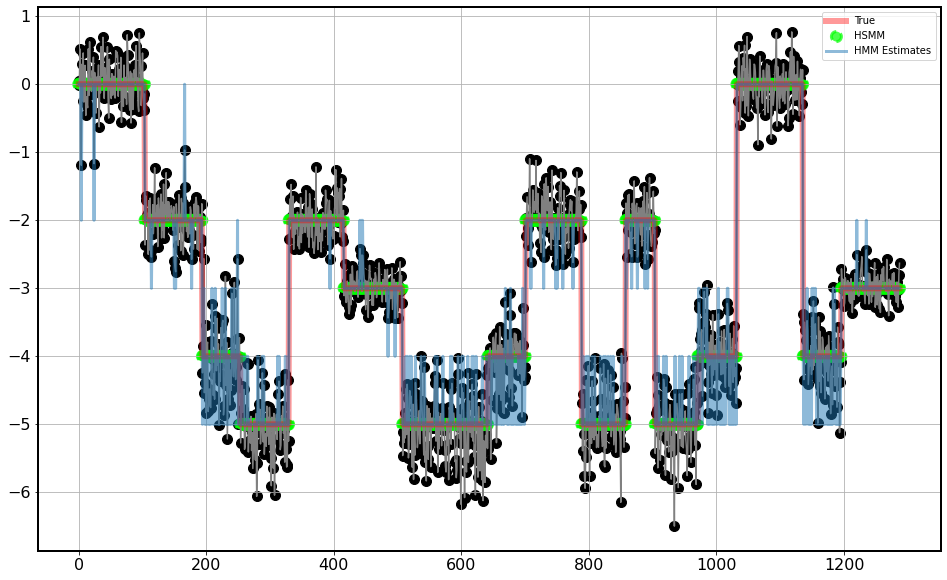

In [176]:
fig, ax = plt.subplots(figsize=(16.18, 10))
ax.plot(hsmm_obs, c='gray')
ax.plot(np.array([means_hsmm[x] for x in hsmm_true_states[:]]), c='red', label='True', alpha=0.4, lw=6)
ax.scatter(np.arange(len(hsmm_obs)), hsmm_obs, s=100, c='black')
ax.scatter(np.arange(len(hsmm_obs))[:], np.array([means_hsmm[x] for x in states_pointwise[:]]), c='lime', label='HSMM', alpha=0.7, lw=3, ls='dashed', s=100)
ek.make_pretty(ax)
plt.plot(np.array([means_hsmm[x] for x in hmm_out[0]]), label = 'HMM Estimates', lw=3, alpha=0.5)
ax.legend()

**Comments:**

Here we see a convincing demonstration of the power of the HSMM over the HMM. The HMM makes many mistakes whereas the HSMM doesn't make any. The drawback of the HSMM is of course its speed (or lack thereof). However, further edits can be made to improve its speed. 

## Optional: Export Data

In [ ]:
hsmm_obs_df = pd.DataFrame({'Observations' : hsmm_obs})

In [ ]:
hsmm_obs_df.to_excel('C:\\Users\\jacgw\\OneDrive\\Documents\\Professional\\NNi\\Application\\generated_test_data_jan5.xlsx')

In [1319]:
hsmm_obs_df.to_csv('C:\\Users\\jacgw\\OneDrive\\Documents\\Professional\\NNi\\Application\\generated_test_data_jan5.csv')

## Visualizing the Discretized PDFs Empirically v.s. Analytically

In [199]:
prob_n_table       = []
hsmm_duration_draw = []
for i in range(len(hsmm_states)):
    prob_n_table.append([hsmm_states[i].prob_n(n, hsmm_sample_rate) for n in range(1, 150)])
    hsmm_duration_draw.append(np.array([hsmm_states[i].duration_instance() for _ in range(5000)]))

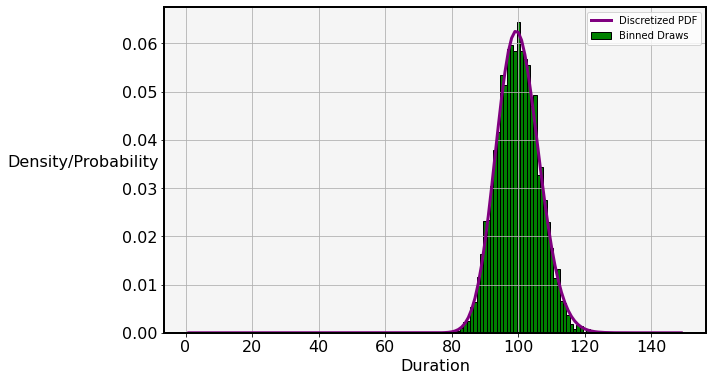

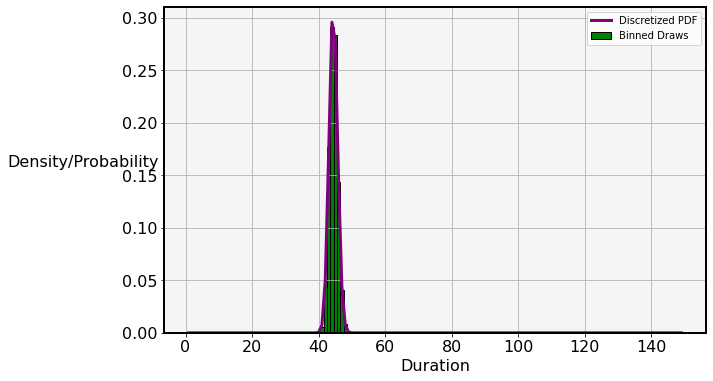

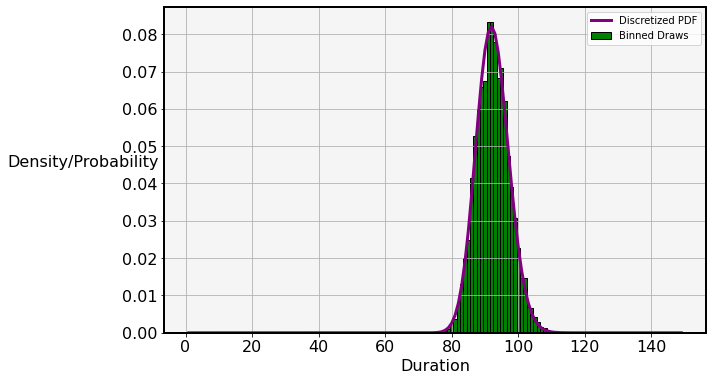

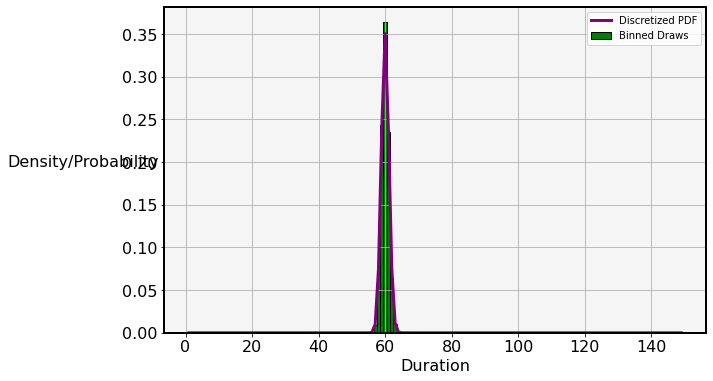

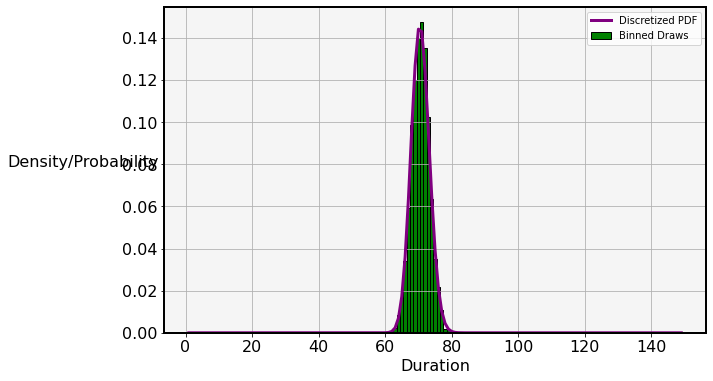

In [211]:
from math import floor, ceil
for i in range(len(hsmm_states)):
    fig, ax = plt.subplots(figsize=np.array([16.18, 10])*0.6)
    ax.plot(np.arange(1, len(prob_n_table[i])+1), prob_n_table[i], label='Discretized PDF', lw=3,c='purple')
    bin_edges = np.arange(floor(min(hsmm_duration_draw[i]*hsmm_sample_rate))-0.5, ceil(max(hsmm_duration_draw[i]*hsmm_sample_rate))+0.5)
    ax.hist(hsmm_duration_draw[i]*hsmm_sample_rate, density=True, label='Binned Draws', bins=bin_edges, edgecolor='black', color='green')
    ek.make_pretty(ax, xTitle='Duration', yTitle='Density/Probability')
    ax.set_facecolor('whitesmoke')
    ax.legend()
    


In [201]:
def get_durations_discretized(obs, sample_rate, durations):
    cudur = np.cumsum(durations)
    
    nobs = len(obs)
    prevailing_state_index = 0
    t_sample = 0
    
    durations_discretized = np.zeros(len(durations))
    count = 1
    for i in range(nobs):
        if t_sample > cudur[prevailing_state_index]:
            durations_discretized[prevailing_state_index] = count
            prevailing_state_index                       += 1
            count                                         = 1
        elif i == nobs-1:
            count += 1
            durations_discretized[prevailing_state_index] = count
        else:
            count += 1
        t_sample += 1./sample_rate
    return durations_discretized

In [202]:
num_steps = 20    # number of state instances per sequence
num_exp   = 1000 # number of sequences to generate

global_durations = []
for i in range(len(hsmm_states)):
    global_durations.append([])
for i in range(num_exp):
    pseudo_out  = create_dataset_2(hsmm_states, hsmm_transition_matrix, hsmm_sample_rate, num_steps)
   
    curr_obs                 = pseudo_out[0]
    curr_true_states         = pseudo_out[1]
    curr_changepoint_indices = pseudo_out[2]
    curr_durations                = pseudo_out[3]

    curr_durations = get_durations_discretized(curr_obs, hsmm_sample_rate, curr_durations)#np.insert(np.array(curr_changepoint_indices[1:]) - np.array(curr_changepoint_indices[:-1]), -1, len(curr_obs)-curr_changepoint_indices[-1])
    for j in range(num_steps):
        global_durations[curr_true_states[j]].append(curr_durations[j])

State-Class #0
Number of instances: 4511
State-Class #1
Number of instances: 3927
State-Class #2
Number of instances: 3172
State-Class #3
Number of instances: 3987
State-Class #4
Number of instances: 4403


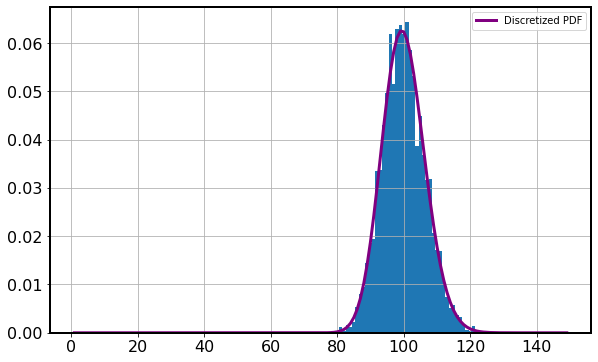

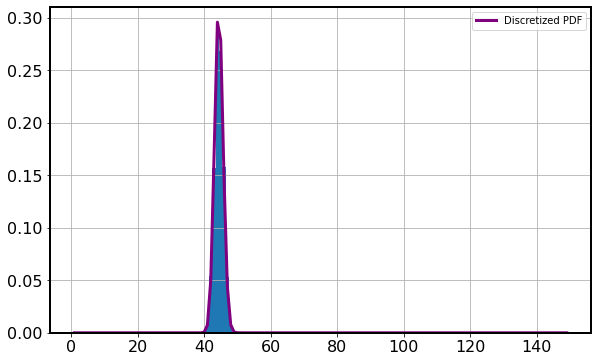

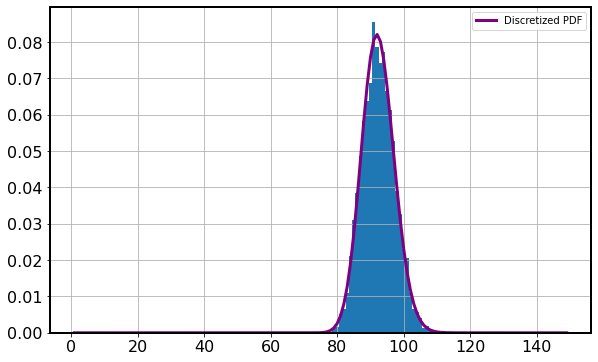

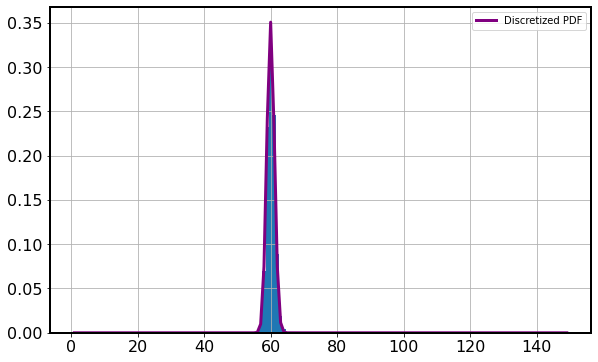

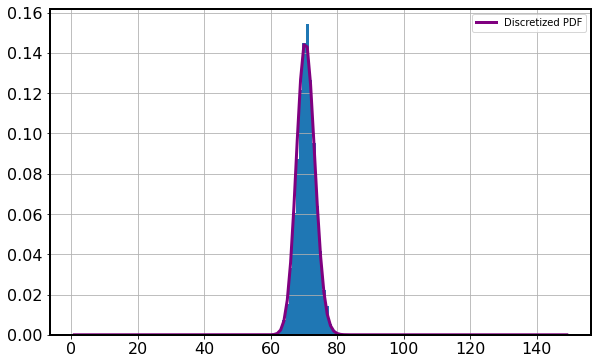

In [212]:
for i in range(len(hsmm_states)):
    fig, ax = plt.subplots(figsize=np.array([16.18, 10])*0.6)
    print('State-Class #{}'.format(i))
    print('Number of instances: {}'.format(len(global_durations[i])))
    bin_edges = np.arange(floor(min(global_durations[i]))-0.5, ceil(max(global_durations[i]))+0.5)
    ax.hist(global_durations[i], bins=bin_edges, density=True)
    ax.plot(np.arange(1, len(prob_n_table[i])+1), prob_n_table[i], label='Discretized PDF', lw=3,c='purple')
    ek.make_pretty(ax)
    plt.legend()